# 멋진 번역기 만들기 & 멋진 챗봇 만들기

## 프로젝트 설명

동일한 Transformer 모델을 사용하여 한 팀은 번역기, 다른 한 팀을 챗봇을 구현한다.

챗봇 구현을 위한 코드로 개발 환경은 코랩으로 진행하였다.

- 데이터 : 한국어 상담 챗봇 생성용 데이터(이별, 사랑 등에 관한 라벨링이 붙어있는 데이터)
- EDA 진행
- 데이터 문장 단위 전처리
- 중복 처리 함수 구현
- 데이터를 questions/answers 변수에 나눠서 저장
- 토큰화
- txt 파일 호출하여 문자열을 리스트로 복원
- lexical_sub() 사용하여 데이터 양 3배 증폭
    - que_corpus : ans_corpus
    - augmented_que_corpus : ans_corpus
    - que_corpus : augmented_ans_corpus
- ans_corpus에 \<SOS\>, \<EOS\> 토큰 추가
- 이후 3배로 증폭된 que_corpus와 ans_corpus 합쳐서 단어 사전 구축, 벡터화 하여 enc_train, dec_train 생성
- 트랜스포머 모델 학습
- 모델 성능 평가

토큰화 : 중복 처리 여부에 따른 실험 진행을 위한 중간 산출물 저장
- 산출물 : que_corpus.txt, ans_corpus.txt
- 데이터 확인 결과 3가지 유형의 중복 존재
    1. 다른 질문에 대한 동일한 대답
        - 가족 여행 가기로 했어 - 온 가족이 모두 마음에 드는 곳으로 가세요
        - 가족 여행 고고 - 온 가족이 모두 마음에 드는 곳으로 가세요
        - 가족 여행 어디로 가지? - 온 가족이 모두 마음에 드는 곳으로 가세요
    2. 동일한 질문에 대한 다른 대답
        - 훔쳐보는 것도 눈치 보임-티가 나니까 눈치가 보이는 거죠!
        - 훔쳐보는 것도 눈치 보임.-훔쳐보는 거 티나나봐요.
    3. 어미 다름
        - 가족들이랑 여행갈거야 -좋은 생각이에요
        - 가족이랑 여행가려고 -좋은 생각이에요
- 실험 1~8 진행 가능 ⇒ case1, case2 ~ case8 디렉토리 생성
    - 1 : 모든 데이터 전부 사용
    - 2 ~ 4 : 한 가지 만 중복 제거
    - 5 ~ 7 : 두 가지 중복 제거
    - 8 : 모든 중복 제거
- 디렉토리 마다 que_corpus.txt, ans_corpus.txt 파일 생성

산출물
- case1~8 디렉토리
- 각 디렉토리 아래에
    - que_corpus.txt
    - ans_corpus.txt
    - aug_que_corpus.txt
    - aug_ans_corpus.txt
    - transformer를 위한 vocab
    - aug_none, aug_1, aug_2, aug_all에 대한 loss, acc, lr 변화 csv 파일
    - Belu, 등의 추가 메트릭
    - 어탠션 맵
    - weights&bias 사용한 시각화 보드

## 프로젝트 루브릭

|출처 노드| 학습목표 | 평가기준 |
|------------|---------|---------|
|10| 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다. | 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다. |
|10| Transformer 번역기 모델이 정상적으로 구동된다. | Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다. |
|10| 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다. | 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다. |
|12| 챗봇 훈련데이터 전처리 과정이 체계적으로 진행되었는가? | 챗봇 훈련데이터를 위한 전처리와 augmentation이 적절히 수행되어 3만개 가량의 훈련데이터셋이 구축되었다. |
|12| transformer 모델을 활용한 챗봇 모델이 과적합을 피해 안정적으로 훈련되었는가? | 과적합을 피할 수 있는 하이퍼파라미터 셋이 적절히 제시되었다. |
|12| 챗봇이 사용자의 질문에 그럴듯한 형태로 답하는 사례가 있는가? | 주어진 예문을 포함하여 챗봇에 던진 질문에 적절히 답하는 사례가 제출되었다. |



# 사전 환경 세팅

## Colab 환경 세팅 함수 정의

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AIFFEL/Deep_Dive/

Mounted at /content/drive
/content/drive/MyDrive/AIFFEL/Deep_Dive


In [2]:
!sudo apt-get update
!sudo apt-get install -y fonts-nanum fonts-noto-cjk
!fc-list | grep -i "nanum\|noto"
!pip install sentencepiece transformers accelerate
!pip install konlpy nltk tqdm gensim
!pip install rouge-score
!sudo apt-get upgrade
!sudo apt-get install -y openjdk-17-jdk
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd ./Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh
%cd /content/drive/MyDrive/AIFFEL/Deep_Dive/work/transformer_chatbot

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,487 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,153 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,834 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports

# 라이브러리 설치 및 호출

## 라이브러리 호출

In [3]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PATH"] += os.pathsep + os.path.join(os.environ["JAVA_HOME"], "bin")

In [79]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import logging

logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

# fontpath = r"C:/Windows/Fonts/malgun.ttf"
fontpath = "/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf"
fontprop = fm.FontProperties(fname=fontpath, size=12)
plt.rcParams["font.family"] = fontprop.get_name()

print(f"설정된 폰트: {fontprop.get_name()}")

설정된 폰트: NanumBarunGothic


In [5]:
import re
import urllib.request
import zipfile
import sentencepiece as spm
import pandas as pd
import random
import math
import ast

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import torch.optim.lr_scheduler as lr_scheduler
from konlpy.tag import Mecab

from tqdm import tqdm
import random

import nltk
import gensim
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

import tempfile
from typing import Literal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 라이브러리 버전 확인

In [6]:
print(np.__version__)
print(pd.__version__)
print(torch.__version__)
print(nltk.__version__)
print(gensim.__version__)

2.0.2
2.2.2
2.9.0+cu126
3.9.1
4.4.0


# 데이터 분석

## 데이터 다운로드 및 열기

In [ ]:
! mkdir data
! wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
! mv ChatbotData.csv ./data/

mkdir: cannot create directory ‘data’: File exists
--2025-11-26 05:40:07--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv [following]
--2025-11-26 05:40:07--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData.csv’

ChatbotData.csv     100%[===================>] 868.99K  --.-KB/s    in 0.04s   

2025-11-26 05:40:07 (20.1 MB/s) - ‘ChatbotData.csv’ saved [889842/889

In [ ]:
# 챗봇 데이터 폴더 경로
# path_to_dataset = '/content/drive/MyDrive/AIFFEL/Deep_Dive/work/transformer_chatbot'
path_to_dataset = './data'

# 개별 파일 경로 설정
path_to_ko_chatbot = os.path.join(path_to_dataset, 'ChatbotData.csv')

## 데이터 확인하기

In [ ]:
raw_data = pd.read_csv(path_to_ko_chatbot).drop('label', axis=1)
raw_data.head()

,Q,A
0,12시 땡!,하루가 또 가네요.
1,1지망 학교 떨어졌어,위로해 드립니다.
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.
4,PPL 심하네,눈살이 찌푸려지죠.


# 데이터 전처리

- 문장 단위 전처리 함수 정의
    - 반복되는 문장 부호 제거
    - 맞춤법 변형 통일
    - 반복 문자 제거
    - 완성형 한글 필터링
    - 이모지, 이모티콘, 특수문자 제거
    - 영어 소문자 변환
    - 연속 공백 하나의 공백으로 치환
    - 앞뒤 공백 제거
    - 등등
- tokenizer 결정 및 데이터 토큰화
- stopword 정의
- max_len 결정

In [ ]:
# 전처리 함수 정의
def preprocess_sentence(text):
    """
    텍스트 전처리 함수
    """
    if pd.isna(text):
        return ""

    text = str(text)

    # 1. 소문자화
    text = text.lower()

    # 2. 반복되는 문장 부호 제거 (2개 이상 → 1개)
    text = re.sub(r'([.!?,])\1+', r'\1', text)

    # 3. 영어/숫자/한글/문장부호만 남기고 모두 삭제
    # 이모지, 이모티콘, 특수문자 자동 제거
    # ' -> 추가
    text = re.sub(r"[^가-힣a-zA-Z0-9\s.!?,']", " ", text)

    # 4. 문장부호 앞뒤로 공백 추가
    text = re.sub(r'([.!?,])', r' \1 ', text)

    # 5. 연속 공백을 하나의 공백으로 교체
    text = re.sub(r'\s+', ' ', text)

    # 6. 앞뒤 공백 제거
    text = text.strip()

    return text


In [ ]:
raw_data['Q'] = raw_data['Q'].apply(preprocess_sentence)
raw_data['A'] = raw_data['A'].apply(preprocess_sentence)

print(raw_data.shape)
raw_data.head()

(11823, 2)


,Q,A
0,12시 땡 !,하루가 또 가네요 .
1,1지망 학교 떨어졌어,위로해 드립니다 .
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .
4,ppl 심하네,눈살이 찌푸려지죠 .


## 중복값 제거

In [ ]:
# 중복 유형 3가지에 대한 처리 함수 구현

# 토큰화

In [ ]:
mecab = Mecab()

def tokenizer(
    texts: pd.Series,
    use_sentencepiece: bool = False,
    sp_model_type: Literal["unigram", "bpe", "char", "word"] = "bpe",
    sp_model_prefix: str = "spm_mecab",
    character_coverage: float = 0.9995,
) -> pd.Series:
    """
    입력: Series (문장)
    출력: Series (토큰 리스트)

    use_sentencepiece = False
      → MeCab 토큰 리스트 그대로 반환

    use_sentencepiece = True
      → MeCab 토큰 → SentencePiece subword 토큰 리스트 반환
         - 1차: vocab_size = MeCab 유니크 토큰 개수로 시도
         - 만약 "Vocabulary size too high ... <= N" 에러 발생 시
           → vocab_size = N 으로 줄여서 자동 재시도
    """

    # 1) MeCab 토큰화
    mecab_tokens = texts.astype(str).apply(mecab.morphs)

    if not use_sentencepiece:
        return mecab_tokens

    # 2) 유니크 토큰 기반 vocab_size 초깃값
    all_tokens = [tok for toks in mecab_tokens for tok in toks]
    unique_tokens = set(all_tokens)
    vocab_size = max(len(unique_tokens), 10)  # 최소 10

    # 3) SentencePiece 학습용 corpus (임시 파일)
    mecab_lines = [" ".join(toks) for toks in mecab_tokens]

    with tempfile.NamedTemporaryFile(
        mode="w", encoding="utf-8", suffix=".txt", delete=False
    ) as tmp:
        corpus_path = tmp.name
        for line in mecab_lines:
            if line.strip():
                tmp.write(line + "\n")

    def _train_spm(vocab_size_int: int):
        cmd = (
            f"--input={corpus_path} "
            f"--model_prefix={sp_model_prefix} "
            f"--vocab_size={vocab_size_int} "
            f"--model_type={sp_model_type} "
            f"--character_coverage={character_coverage} "
            f"--pad_id=0 --pad_piece=<pad> "
            f"--unk_id=1 --unk_piece=<unk> "
            f"--bos_id=2 --bos_piece=<bos> "
            f"--eos_id=3 --eos_piece=<eos>"
        )
        spm.SentencePieceTrainer.Train(cmd)

    # 4) SentencePiece 학습 (에러 나면 자동으로 vocab_size 줄여서 재시도)
    try:
        _train_spm(vocab_size)
    except RuntimeError as e:
        msg = str(e)
        # "Please set it to a value <= 2858" 에서 2858만 뽑기
        m = re.search(r"<=\s*(\d+)", msg)
        if m:
            suggested_max = int(m.group(1))
            # 혹시 너무 작으면 10 이상으로
            vocab_size2 = max(suggested_max, 10)
            print(
                f"[SentencePiece] vocab_size {vocab_size} → {vocab_size2} 로 자동 조정 후 재시도합니다."
            )
            _train_spm(vocab_size2)
            vocab_size = vocab_size2
        else:
            # 다른 종류의 RuntimeError면 그대로 다시 던짐
            raise

    # 5) 임시 corpus 파일 삭제
    try:
        os.remove(corpus_path)
    except OSError:
        pass

    # 6) SentencePiece 모델 로드
    sp = spm.SentencePieceProcessor()
    sp.Load(f"{sp_model_prefix}.model")

    # 7) SP 토큰화
    sp_pieces_list = []
    for line in tqdm(mecab_lines, desc=f"SentencePiece tokenizing ({sp_model_type})"):
        pieces = sp.EncodeAsPieces(line)
        sp_pieces_list.append(pieces)

    return pd.Series(sp_pieces_list, index=texts.index)


In [7]:
save_path = "/content/drive/MyDrive/AIFFEL/Deep_Dive/work/transformer_chatbot/experiment/case1"

In [ ]:
raw_data["Q_mecab_tokens"] = tokenizer(
    raw_data["Q"],
    use_sentencepiece=False,
)

# raw_data["Q_spm_unigram_tokens"] = tokenizer(
#     raw_data["Q"],
#     use_sentencepiece=True,
#     sp_model_type="unigram",
#     sp_model_prefix="spm_unigram_kor_mecab_Q",
#     sp_model_dir=save_path
# )

# raw_data["Q_spm_bpe_tokens"] = tokenizer(
#     raw_data["Q"],
#     use_sentencepiece=True,
#     sp_model_type="bpe",
#     sp_model_prefix="spm_bpe_kor_mecab_Q",
#     sp_model_dir=save_path
# )

In [ ]:
raw_data["A_mecab_tokens"] = tokenizer(
    raw_data["A"],
    use_sentencepiece=False,
)

# raw_data["A_spm_unigram_tokens"] = tokenizer(
#     raw_data["A"],
#     use_sentencepiece=True,
#     sp_model_type="unigram",
#     sp_model_prefix="spm_unigram_kor_mecab_A",
#     sp_model_dir=save_path
# )

# raw_data["A_spm_bpe_tokens"] = tokenizer(
#     raw_data["A"],
#     use_sentencepiece=True,
#     sp_model_type="bpe",
#     sp_model_prefix="spm_bpe_kor_mecab_A",
#     sp_model_dir=save_path
# )

In [ ]:
raw_data.head()

,Q,A,Q_mecab_tokens,A_mecab_tokens
0,12시 땡 !,하루가 또 가네요 .,"[12, 시, 땡, !]","[하루, 가, 또, 가, 네요, .]"
1,1지망 학교 떨어졌어,위로해 드립니다 .,"[1, 지망, 학교, 떨어졌, 어]","[위로, 해, 드립니다, .]"
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠 .,"[3, 박, 4, 일, 놀, 러, 가, 고, 싶, 다]","[여행, 은, 언제나, 좋, 죠, .]"
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠 .,"[3, 박, 4, 일, 정도, 놀, 러, 가, 고, 싶, 다]","[여행, 은, 언제나, 좋, 죠, .]"
4,ppl 심하네,눈살이 찌푸려지죠 .,"[ppl, 심하, 네]","[눈살, 이, 찌푸려, 지, 죠, .]"


In [ ]:
train_df, test_df = train_test_split(raw_data, test_size=0.2, random_state=42)

In [ ]:
train_df["Q_mecab_tokens"].to_csv(save_path+"/que_train_corpus.csv", index=False, header=False)
train_df["A_mecab_tokens"].to_csv(save_path+"/ans_train_corpus.csv", index=False, header=False)
test_df["Q_mecab_tokens"].to_csv(save_path+"/que_test_corpus.csv", index=False, header=False)
test_df["A_mecab_tokens"].to_csv(save_path+"/ans_test_corpus.csv", index=False, header=False)

# 데이터 Augmentation

In [ ]:
model_name = "facebook/mbart-large-50-many-to-many-mmt"

tokenizer = MBart50TokenizerFast.from_pretrained(model_name)
model = MBartForConditionalGeneration.from_pretrained(model_name).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

In [ ]:
def translate_mbart(texts, src_lang: str, tgt_lang: str,
                    tokenizer: MBart50TokenizerFast,
                    model: MBartForConditionalGeneration,
                    max_length: int = 128):
    """
    texts: str 또는 str 리스트
    src_lang: 'ko_KR', 'en_XX' 등
    tgt_lang: 'ko_KR', 'en_XX' 등
    """
    if isinstance(texts, str):
        texts = [texts]

    # 입력 언어 설정
    tokenizer.src_lang = src_lang

    enc = tokenizer(
        texts,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=max_length,
    ).to(device)

    # 출력 언어 강제 설정
    forced_bos_token_id = tokenizer.lang_code_to_id[tgt_lang]

    with torch.no_grad():
        gen = model.generate(
            **enc,
            forced_bos_token_id=forced_bos_token_id,
            max_length=max_length,
        )

    outputs = [tokenizer.decode(g, skip_special_tokens=True) for g in gen]
    return outputs


In [ ]:
def back_translate_ko_en_ko(text: str,
                            tokenizer: MBart50TokenizerFast,
                            model: MBartForConditionalGeneration,
                            max_length: int = 128) -> str:
    """
    한국어 문장 1개를 ko→en→ko back-translation 해서 한국어 문장으로 반환
    """
    if not isinstance(text, str):
        text = str(text)

    # 1) ko -> en
    en_text = translate_mbart(
        text,
        src_lang="ko_KR",
        tgt_lang="en_XX",
        tokenizer=tokenizer,
        model=model,
        max_length=max_length,
    )[0]

    # 2) en -> ko
    ko_bt_text = translate_mbart(
        en_text,
        src_lang="en_XX",
        tgt_lang="ko_KR",
        tokenizer=tokenizer,
        model=model,
        max_length=max_length,
    )[0]

    return ko_bt_text

In [ ]:
def back_translate_series_ko_en_ko(series: pd.Series,
                                   tokenizer: MBart50TokenizerFast,
                                   model: MBartForConditionalGeneration,
                                   max_length: int = 128) -> pd.Series:
    bt_list = []
    for text in tqdm(series, desc="Back-translating"):
        bt_text = back_translate_ko_en_ko(
            text,
            tokenizer=tokenizer,
            model=model,
            max_length=max_length,
        )
        bt_list.append(bt_text)
    return pd.Series(bt_list, index=series.index)

In [ ]:
def text_to_tokens_mecab(text):
    """
    '오늘날씨어때?' -> ['오늘', '날씨', '어때', '?']
    """
    return mecab.morphs(text)


In [ ]:
bt_Q = back_translate_series_ko_en_ko(train_df["Q"], tokenizer, model)
bt_A = back_translate_series_ko_en_ko(train_df["A"], tokenizer, model)

bt_Q = bt_Q.apply(text_to_tokens_mecab)
bt_A = bt_A.apply(text_to_tokens_mecab)

bt_Q.to_csv(save_path + "/bt_train_Q_sentence.csv", index=False, header=False)
bt_A.to_csv(save_path + "/bt_train_A_sentence.csv", index=False, header=False)

Back-translating: 100%|██████████| 9458/9458 [1:20:34<00:00,  1.96it/s]


# 데이터 호출 및 train_test_split

In [8]:
q = pd.read_csv(save_path + "/que_train_corpus.csv", header=None)
a = pd.read_csv(save_path + "/ans_train_corpus.csv", header=None)
aug_q = pd.read_csv(save_path + "/bt_train_Q_sentence.csv", header=None)
aug_a = pd.read_csv(save_path + "/bt_train_A_sentence.csv", header=None)

# 2) 컬럼명 rename
q.columns = ["Q"]
a.columns = ["A"]
aug_q.columns = ["Q"]
aug_a.columns = ["A"]

# 3) literal_eval로 리스트 복원
q["Q"] = q["Q"].apply(ast.literal_eval)
a["A"] = a["A"].apply(ast.literal_eval)
aug_q["Q"] = aug_q["Q"].apply(ast.literal_eval)
aug_a["A"] = aug_a["A"].apply(ast.literal_eval)

# 1) 기본 조합: q + a
pair1 = pd.DataFrame({
    "Q": q["Q"],
    "A": a["A"],
})

# 2) q + aug_a
pair2 = pd.DataFrame({
    "Q": q["Q"],
    "A": aug_a["A"],
})

# 3) aug_q + a
pair3 = pd.DataFrame({
    "Q": aug_q["Q"],
    "A": a["A"],
})

# 4) 모두 합치기
data = pd.concat([pair1, pair2, pair3], ignore_index=True)
print(data.shape)
data.tail()

(28374, 2)


,Q,A
28369,"[저, 는, 좋, 아, 했, 지만, 불평, 할, 수, 없, 었, 습니다, .]","[애틋, 한, 사랑, 이, 네요, .]"
28370,"[화장실, !]","[화장실, 가, 세요, .]"
28371,"[6, 개월, 후, ,, 왜, 그럴까요, ?]","[물리, 적, 시간, 에, 비례, 하, 지, 않, 으니까요, .]"
28372,"[저, 는, 문제, 입니다, .]","[당신, 은, 하나, 밖에, 없, 는, 소중, 한, 사람, 이, 에요, .]"
28373,"[요즘, 은, 혼자, 있, 는, 것, 이, 멋지, 죠, .]","[때론, 혼자, 인, 게, 편할, 때, 가, 있, 죠, .]"


In [9]:
VOCAB_SIZE = 20000  # including specials

SPECIAL_TOKENS = ["<pad>", "<unk>", "<s>", "</s>"]

In [10]:
from collections import Counter

def build_vocab_from_tokenized_data(data, vocab_size=20000, specials=None):
    """
    data: Q, A 컬럼에 토큰 리스트가 들어있는 DataFrame
    """
    if specials is None:
        specials = ["<pad>", "<unk>", "<s>", "</s>"]

    counter = Counter()

    # Q, A 모든 토큰 모으기
    for toks in data["Q"]:
        counter.update(toks)
    for toks in data["A"]:
        counter.update(toks)

    # frequency 기준 상위 vocab_size - len(specials) 선정
    cap = vocab_size - len(specials)
    most_common_tokens = [t for t, _ in counter.most_common(cap)]

    # itos / stoi 만들기
    itos = specials + most_common_tokens
    stoi = {tok: i for i, tok in enumerate(itos)}

    return stoi, itos, counter


In [11]:
def add_sos_eos(tokens):
    """
    tokens: list[str]
    출력: ['<s>', '...', '</s>']
    """
    return ["<s>"] + tokens + ["</s>"]

In [12]:
def encode_tokens(tokens, stoi):
    unk_id = stoi["<unk>"]
    return [stoi.get(tok, unk_id) for tok in tokens]

In [13]:
# -----------------------------------------
# 1) vocab 만들기
# -----------------------------------------

stoi, itos, counter = build_vocab_from_tokenized_data(
    data,
    vocab_size=VOCAB_SIZE,
    specials=SPECIAL_TOKENS
)

print("Vocab size:", len(itos))

Vocab size: 8567


In [14]:
# -----------------------------------------
# 2) 문장 양쪽에 <s>, </s> 추가
# -----------------------------------------

data["Q_with_sos_eos"] = data["Q"].apply(add_sos_eos)
data["A_with_sos_eos"] = data["A"].apply(add_sos_eos)


In [15]:
# -----------------------------------------
# 3) ID 시퀀스로 변환
# -----------------------------------------

data["Q_ids"] = data["Q_with_sos_eos"].apply(lambda x: encode_tokens(x, stoi))
data["A_ids"] = data["A_with_sos_eos"].apply(lambda x: encode_tokens(x, stoi))


print("샘플 Q_ids:", data["Q_ids"].iloc[0])
print("샘플 A_ids:", data["A_ids"].iloc[0])

샘플 Q_ids: [2, 680, 611, 19, 3]
샘플 A_ids: [2, 41, 72, 152, 1213, 7, 54, 4, 3]


In [16]:
import torch

MAX_LEN = 30

def pad_sequences_custom(sequences, max_len=50, pad_value=0, eos_value=None):
    padded_sequences = []

    for seq in sequences:
        # 초과는 자르고
        if len(seq) > max_len:
            seq = seq[:max_len]
            if eos_value is not None:
                # 만약 기존 잘린 구간 안에 eos_value가 하나라도 있으면 ok
                if eos_value not in seq:
                    seq[-1] = eos_value
        # 부족하면 pad_value 채우기
        else:
            seq = seq + [pad_value] * (max_len - len(seq))

        padded_sequences.append(seq)

    return torch.tensor(padded_sequences, dtype=torch.long)


PAD_ID = stoi["<pad>"]
EOS_ID = stoi["</s>"]

enc_ndarray = pad_sequences_custom(
    data["Q_ids"].tolist(),
    max_len=MAX_LEN,
    pad_value=PAD_ID,
    eos_value=EOS_ID,
)

dec_ndarray = pad_sequences_custom(
    data["A_ids"].tolist(),
    max_len=MAX_LEN,
    pad_value=PAD_ID,
    eos_value=EOS_ID,
)

print(enc_ndarray.shape)
print(dec_ndarray.shape)

torch.Size([28374, 30])
torch.Size([28374, 30])


In [17]:
from torch.utils.data import TensorDataset, DataLoader
import torch

BATCH_SIZE = 64

enc_train, enc_valid, dec_train, dec_valid = train_test_split(
    enc_ndarray, dec_ndarray, test_size=0.1, random_state=42
)

train_dataset = TensorDataset(enc_train, dec_train)
valid_dataset = TensorDataset(enc_valid, dec_valid)

BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# 가설 설정

## Augmentation 방식에 따라 모델 성능이 다를 것이다.
통제 변인 : 파라미터, 데이터 split 비율, random seed, 모델 구조

종속 변인 : Augmentation 방식을 3가지로 다르게 진행한다.

# 모델 학습 파이프라인 설계
전처리 완료된 데이터 사용

사용 모델 :

epochs :

early-stopping 조건 :

...

출력 결과 형식 정리

시각화 방식 정리

현재 셀 아래에 코드 셀 추가 후 공통으로 사용할 변수 정의

# 모델 구현

## Tranformer

In [18]:
# Positional Encoding 구현
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, (2*(i//2)) / np.float32(d_model))

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])

    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

    return sinusoid_table

In [19]:
def generate_padding_mask(seq: torch.Tensor) -> torch.Tensor:
    """
    seq: shape [batch_size, seq_len]의 입력 (토큰 ID 텐서)
    반환: shape [batch_size, 1, 1, seq_len]의 패딩 마스크
         (seq == 0)인 위치가 1, 나머지는 0
    """
    # (seq == 0)은 불리언 텐서를 반환 -> float()로 형변환 -> (1.0 or 0.0)
    # 차원 확장: [batch_size, seq_len] → [batch_size, 1, 1, seq_len]
    return (seq == 0).unsqueeze(1).unsqueeze(2).float()


def generate_lookahead_mask(size: int) -> torch.Tensor:
    """
    size: 문장(시퀀스) 길이
    반환: shape [size, size],
         i < j (대각선 위)에 해당하는 위치가 1, 아닌 곳은 0
         (미래 토큰을 가리기 위한 마스크)
    """
    # triu(diagonal=1)은 주대각선 위가 1, 아래가 0인 텐서를 만들어 줌
    return torch.triu(torch.ones(size, size), diagonal=1)


def generate_masks(src: torch.Tensor, tgt: torch.Tensor):
    """
    src, tgt: shape [batch_size, seq_len]
    3가지 마스크를 반환:
      - enc_mask: 인코더 입력용 패딩 마스크
      - dec_enc_mask: 디코더-인코더 어텐션용 패딩 마스크
      - dec_mask: 디코더 자기어텐션용 마스크(룩어헤드 + 패딩)

    각각의 shape:
      - enc_mask, dec_enc_mask: [batch_size, 1, 1, src_seq_len]
      - dec_mask: [batch_size, 1, tgt_seq_len, tgt_seq_len]
    """
    # 1) 인코더 입력용 패딩 마스크
    enc_mask = generate_padding_mask(src)
    # 2) 디코더에서 인코더 값을 볼 때 사용하는 마스크 (src 마스크 재사용)
    dec_enc_mask = generate_padding_mask(src)

    # 3) 디코더 자기어텐션 마스크 (미래 토큰 방지 룩어헤드 + tgt 자체 패딩 마스크)
    dec_lookahead_mask = generate_lookahead_mask(tgt.shape[1])  # [tgt_seq_len, tgt_seq_len]
    dec_tgt_padding_mask = generate_padding_mask(tgt)           # [batch_size, 1, 1, tgt_seq_len]

    # 룩어헤드 마스크를 (batch 차원과 head 차원을 가상으로) 확장
    dec_lookahead_mask = dec_lookahead_mask.unsqueeze(0).unsqueeze(1)  # [1, 1, seq_len, seq_len]

    # 패딩 + 룩어헤드 마스크 병합
    # 브로드캐스팅에 의해 shape [batch_size, 1, tgt_seq_len, tgt_seq_len]이 됨

    dec_tgt_padding_mask = dec_tgt_padding_mask.to(device)
    dec_lookahead_mask = dec_lookahead_mask.to(device)

    dec_mask = torch.max(dec_tgt_padding_mask, dec_lookahead_mask)

    return enc_mask, dec_enc_mask, dec_mask

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model을 num_heads로 나눈 만큼이 각 head가 담당할 차원 수
        self.depth = d_model // num_heads

        # Query, Key, Value를 구하는 선형 레이어
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        # 최종적으로 head들의 출력을 결합해주는 선형 레이어
        self.linear = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Q, K, V:  [batch_size, num_heads, seq_len, depth]
        mask:     [batch_size, 1, seq_len, seq_len] 혹은
                  [batch_size, num_heads, seq_len, seq_len]
                  (어텐션에서 제외할 위치=1, 사용할 위치=0)
        """
        # d_k = depth
        d_k = Q.size(-1)  # K.shape[-1]도 동일
        # Q와 K의 전치 곱: (batch_size, num_heads, seq_len, seq_len)
        QK = torch.matmul(Q, K.transpose(-1, -2))

        # 스케일링
        scaled_qk = QK / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

        # 마스크가 있는 경우 -1e9(매우 작은 수)를 더하여 softmax 후 확률이 0에 가깝도록 처리
        if mask is not None:
            scaled_qk = scaled_qk + (mask * -1e9)

        attentions = F.softmax(scaled_qk, dim=-1)  # (batch_size, num_heads, seq_len, seq_len)
        out = torch.matmul(attentions, V)         # (batch_size, num_heads, seq_len, depth)

        return out, attentions

    def split_heads(self, x):
        """
        x: [batch_size, seq_len, d_model]
        반환: [batch_size, num_heads, seq_len, depth]
        """
        bsz, seq_len, _ = x.size()
        # d_model -> (num_heads * depth)이므로 view로 재배치
        x = x.view(bsz, seq_len, self.num_heads, self.depth)
        # (batch_size, seq_len, num_heads, depth) -> (batch_size, num_heads, seq_len, depth)
        x = x.permute(0, 2, 1, 3)
        return x

    def combine_heads(self, x):
        """
        x: [batch_size, num_heads, seq_len, depth]
        반환: [batch_size, seq_len, d_model]
        """
        bsz, num_heads, seq_len, depth = x.size()
        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(bsz, seq_len, self.d_model)
        return x

    def forward(self, Q, K, V, mask=None):
        """
        Q, K, V: [batch_size, seq_len, d_model]
        mask:    [batch_size, 1, seq_len, seq_len] 혹은
                 [batch_size, num_heads, seq_len, seq_len]
        """
        # W_q, W_k, W_v는 각각 (d_model -> d_model) 선형 변환
        WQ = self.W_q(Q)  # [batch_size, seq_len, d_model]
        WK = self.W_k(K)  # [batch_size, seq_len, d_model]
        WV = self.W_v(V)  # [batch_size, seq_len, d_model]

        # 멀티헤드 분할
        WQ_splits = self.split_heads(WQ)  # [batch_size, num_heads, seq_len, depth]
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)

        # Scaled dot-product attention
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask
        )

        # head 결과 결합 후 최종 선형
        out = self.combine_heads(out)  # [batch_size, seq_len, d_model]
        out = self.linear(out)         # [batch_size, seq_len, d_model]

        return out, attention_weights

In [21]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.relu(self.fc1(x))  # 첫 번째 Dense + ReLU
        out = self.fc2(out)          # 두 번째 Dense
        return out

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        # nn.LayerNorm은 마지막 차원(d_model)을 기준으로 정규화
        self.norm_1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_2 = nn.LayerNorm(d_model, eps=1e-6)

        self.do = nn.Dropout(dropout)

    def forward(self, x, mask):
        # Multi-Head Attention 단계
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.do(out)
        out = out + residual  # residual connection

        # Position-Wise Feed Forward 단계
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.do(out)
        out = out + residual  # residual connection

        return out, enc_attn

In [23]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_2 = nn.LayerNorm(d_model, eps=1e-6)
        self.norm_3 = nn.LayerNorm(d_model, eps=1e-6)

        self.do = nn.Dropout(dropout)

    def forward(self, x, enc_out, dec_enc_mask, padding_mask):
        # Masked Multi-Head Attention
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, mask=padding_mask)
        out = self.do(out)
        out = out + residual

        # Encoder-Decoder Multi-Head Attention (주의: Q, K, V 순서)
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, mask=dec_enc_mask)
        out = self.do(out)
        out = out + residual

        # Position-Wise Feed Forward Network
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.do(out)
        out = out + residual

        return out, dec_attn, dec_enc_attn

In [24]:
class Encoder(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = nn.ModuleList(
            [EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        )
        self.do = nn.Dropout(dropout)  # 필요 시 입력에 dropout 적용 가능

    def forward(self, x, mask):
        out = x
        enc_attns = []
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        return out, enc_attns

# 사용 예시: Encoder 인스턴스 생성 후 forward 호출
# encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
# out, enc_attns = encoder(x, mask)

In [25]:
class Decoder(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = nn.ModuleList(
            [DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(n_layers)]
        )

    def forward(self, x, enc_out, dec_enc_mask, padding_mask):
        out = x
        dec_attns = []
        dec_enc_attns = []
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = self.dec_layers[i](out, enc_out, dec_enc_mask, padding_mask)
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        return out, dec_attns, dec_enc_attns

In [26]:
import math

class Transformer(nn.Module):
    def __init__(self, n_layers, d_model, n_heads, d_ff,
                 src_vocab_size, tgt_vocab_size, pos_len,
                 dropout=0.2, shared_fc=True, shared_emb=False):
        super(Transformer, self).__init__()
        # d_model은 스케일링에 사용되므로 float으로 저장
        self.d_model = float(d_model)

        # Embedding 레이어: shared_emb True면 동일한 임베딩을 사용합니다.
        if shared_emb:
            self.enc_emb = self.dec_emb = nn.Embedding(src_vocab_size, d_model)
        else:
            self.enc_emb = nn.Embedding(src_vocab_size, d_model)
            self.dec_emb = nn.Embedding(tgt_vocab_size, d_model)

        # Positional encoding (넘파이 버전 결과를 torch.Tensor로 변환)
        pos_encoding_np = positional_encoding(pos_len, d_model)
        # 파라미터로 등록하지 않고 고정값이므로 buffer로 등록합니다.
        self.register_buffer("pos_encoding", torch.tensor(pos_encoding_np, dtype=torch.float32))

        self.do = nn.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = nn.Linear(d_model, tgt_vocab_size)

        self.shared_fc = shared_fc
        if shared_fc:
            # fc 레이어와 디코더 임베딩의 weight를 공유합니다.
            self.fc.weight = self.dec_emb.weight

    def embedding(self, emb, x):
        """
        emb: 임베딩 레이어
        x: [batch_size, seq_len] (토큰 인덱스)
        """
        seq_len = x.size(1)
        out = emb(x)  # [batch_size, seq_len, d_model]
        if self.shared_fc:
            out = out * math.sqrt(self.d_model)
        # pos_encoding: [pos_len, d_model] → [1, pos_len, d_model] 후 슬라이싱
        out = out + self.pos_encoding[:seq_len, :].unsqueeze(0)
        out = self.do(out)
        return out

    def forward(self, enc_in, dec_in, enc_mask, dec_enc_mask, dec_mask):
        """
        enc_in: [batch_size, src_seq_len]
        dec_in: [batch_size, tgt_seq_len]
        enc_mask, dec_enc_mask, dec_mask: 마스킹 텐서들
        """
        # Embedding 및 positional encoding 적용
        enc_in_emb = self.embedding(self.enc_emb, enc_in)
        dec_in_emb = self.embedding(self.dec_emb, dec_in)

        # Encoder와 Decoder 통과
        enc_out, enc_attns = self.encoder(enc_in_emb, enc_mask)
        dec_out, dec_attns, dec_enc_attns = self.decoder(dec_in_emb, enc_out, dec_enc_mask, dec_mask)

        logits = self.fc(dec_out)
        return logits, enc_attns, dec_attns, dec_enc_attns

In [27]:
class LearningRateScheduler:
    def __init__(self, d_model, warmup_steps=60): # 4000
        self.d_model = d_model
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # step을 float으로 변환하여 지수 연산이 제대로 수행되도록 함
        step = float(step)
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        return (self.d_model ** -0.5) * min(arg1, arg2)

In [28]:
def loss_function(real, pred):
    real = real.to(device)
    pred = pred.to(device)

    loss_ = F.cross_entropy(
        pred.contiguous().view(-1, pred.size(-1)),
        real.contiguous().view(-1),
        reduction='none'
    )
    loss_ = loss_.view(real.size())

    mask = (real != 0).float()

    valid_tokens = mask.sum().item()
    if valid_tokens == 0:
        print("⚠ mask.sum() == 0 (all PAD). Set loss=0.")
        return torch.tensor(0.0, device=device)
    if valid_tokens < 5:
        print(f"⚠ very small valid_tokens: {valid_tokens}")

    loss_ = loss_ * mask
    return loss_.sum() / valid_tokens

In [29]:
def validate_epoch(model, dataloader):
    model.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            # teacher forcing 구조 동일
            tgt_in = tgt[:, :-1]
            gold = tgt[:, 1:]

            enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

            src = src.to(device)
            tgt_in = tgt_in.to(device)
            gold = gold.to(device)
            enc_mask = enc_mask.to(device)
            dec_enc_mask = dec_enc_mask.to(device)
            dec_mask = dec_mask.to(device)

            preds, _, _, _ = transformer(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)
            loss = loss_function(gold, preds)

            total_loss += loss.item()
            count += 1

    return total_loss / max(count, 1)

# 모델 학습 함수 정의

In [30]:
def train_step(src, tgt, model, optimizer):
    model.train()  # 모델을 training 모드로 전환
    optimizer.zero_grad()

    # tgt의 오른쪽 시프트: decoder input과 gold target 분리
    tgt_in = tgt[:, :-1]  # Decoder의 입력
    gold = tgt[:, 1:]     # Decoder의 정답(target)

    # 마스크 생성 (generate_masks는 PyTorch용으로 변환된 함수여야 합니다)
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt_in)

    src = src.to(device)
    tgt_in = tgt_in.to(device)
    enc_mask = enc_mask.to(device)
    dec_enc_mask = dec_enc_mask.to(device)
    dec_mask = dec_mask.to(device)

    # 모델 forward pass
    predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt_in, enc_mask, dec_enc_mask, dec_mask)

    # loss 계산
    loss = loss_function(gold, predictions)

    # 역전파 수행 및 파라미터 업데이트
    loss.backward()
    optimizer.step()

    return loss, enc_attns, dec_attns, dec_enc_attns

# 모델 평가 지표 함수 정의

In [31]:
import math
import torch
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

In [32]:
def compute_perplexity(avg_loss):
    if math.isinf(avg_loss) or math.isnan(avg_loss):
        return float("inf")
    if avg_loss > 50:  # exp(50) ≈ 3e21, 그 이상은 사실상 "무한대 취급"해도 됨
        return float("inf")
    return math.exp(avg_loss)

In [33]:
def ids_to_sentence(
    ids,
    itos,
    pad_token: str = "<pad>",
    bos_token: str = "<s>",
    eos_token: str = "</s>",
):
    if torch.is_tensor(ids):
        ids = ids.tolist()

    tokens = []
    V = len(itos)

    for i in ids:
        # 🔴 여기가 새로 추가된 부분: 범위 밖 ID 처리
        if i < 0 or i >= V:
            # 범위 밖 인덱트는 그냥 <unk>로 처리하거나 스킵
            # 한 줄 선택해서 사용하면 됨. 기본은 <unk>로 치환.
            tokens.append("<unk>")
            # continue  # 만약 완전 무시하고 싶으면 이걸로
            continue

        tok = itos[i]

        if tok == pad_token:
            continue
        if tok == bos_token:
            continue
        if tok == eos_token:
            break

        tokens.append(tok)

    return " ".join(tokens)


In [34]:
from nltk.translate.meteor_score import meteor_score
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # optional, 하지만 METEOR에서 쓰임

def compute_meteor(references, hypotheses):
    """
    references: list[str]  (정답 문장, 공백으로 토큰 되어 있다고 가정)
    hypotheses: list[str]  (모델 예측 문장)
    """
    assert len(references) == len(hypotheses)
    scores = []

    for ref, hyp in zip(references, hypotheses):
        # 혹시라도 None이나 "" 들어와도 터지지 않게 방어
        ref = ref if isinstance(ref, str) else ""
        hyp = hyp if isinstance(hyp, str) else ""

        ref_tokens = ref.split()  # ["오늘", "날씨", "어때"]
        hyp_tokens = hyp.split()

        # 둘 다 완전 빈 문장이면 점수를 0으로 처리하거나 1로 처리할지 선택
        if not ref_tokens and not hyp_tokens:
            scores.append(0.0)
            continue

        # meteor_score의 첫 인자는 [ref_tokens], 두 번째는 hyp_tokens
        score = meteor_score([ref_tokens], hyp_tokens)
        scores.append(score)

    return sum(scores) / len(scores) if scores else 0.0



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [35]:
def compute_rouge(references, hypotheses):
    """
    references: list[str]
    hypotheses: list[str]
    return: 평균 ROUGE-1 / ROUGE-2 / ROUGE-L (F1 기준)
    """
    assert len(references) == len(hypotheses)

    scorer = rouge_scorer.RougeScorer(
        ["rouge1", "rouge2", "rougeL"],
        use_stemmer=False  # 한국어니까 stemming 안 씀
    )

    rouge1_f, rouge2_f, rougeL_f = 0.0, 0.0, 0.0

    for ref, hyp in zip(references, hypotheses):
        scores = scorer.score(ref, hyp)
        rouge1_f += scores["rouge1"].fmeasure
        rouge2_f += scores["rouge2"].fmeasure
        rougeL_f += scores["rougeL"].fmeasure

    n = len(references) if references else 1
    return {
        "rouge1": rouge1_f / n,
        "rouge2": rouge2_f / n,
        "rougeL": rougeL_f / n,
    }


In [36]:
PAD_ID = stoi["<pad>"]
BOS_ID = stoi["<s>"]
EOS_ID = stoi["</s>"]
MAX_LEN = 30  # 이미 위에서 쓰던 값

def greedy_decode_batch(model, src_batch, generate_masks, max_len=MAX_LEN):
    """
    src_batch: [B, src_len] (이미 device에 올려진 상태라고 가정)
    generate_masks: 너가 이미 쓰고 있는 함수 (src, tgt_in) -> (enc_mask, dec_enc_mask, dec_mask)
    return: pred_ids_batch: [B, max_len] (BOS부터 EOS 포함)
    """
    model.eval()
    batch_size = src_batch.size(0)

    # 시작 토큰만 있는 decoder 입력 [B, 1]
    tgt_in = torch.full(
        (batch_size, 1),
        BOS_ID,
        dtype=torch.long,
        device=src_batch.device,
    )

    finished = torch.zeros(batch_size, dtype=torch.bool, device=src_batch.device)

    with torch.no_grad():
        for _ in range(max_len - 1):  # 이미 BOS 하나 들어가 있으니까
            enc_mask, dec_enc_mask, dec_mask = generate_masks(src_batch, tgt_in)
            enc_mask = enc_mask.to(src_batch.device)
            dec_enc_mask = dec_enc_mask.to(src_batch.device)
            dec_mask = dec_mask.to(src_batch.device)

            preds, _, _, _ = model(src_batch, tgt_in, enc_mask, dec_enc_mask, dec_mask)
            # preds: [B, cur_len, vocab]
            next_token_logits = preds[:, -1, :]  # 마지막 시점만

            next_tokens = next_token_logits.argmax(dim=-1)  # [B]

            # 이미 끝난 문장은 그대로 pad로 채움
            next_tokens = next_tokens.masked_fill(finished, PAD_ID)

            tgt_in = torch.cat([tgt_in, next_tokens.unsqueeze(1)], dim=1)

            finished = finished | (next_tokens == EOS_ID)
            if finished.all():
                break

    return tgt_in

In [37]:
def collect_refs_hyps(
    model,
    dataloader,
    itos,
    device,
    generate_masks,
):
    references = []
    hypotheses = []

    model.eval()
    with torch.no_grad():
        for src_batch, tgt_batch in dataloader:
            src_batch = src_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            # greedy decoding으로 예측 시퀀스 생성
            pred_batch = greedy_decode_batch(model, src_batch, generate_masks, max_len=MAX_LEN)

            for ref_ids, hyp_ids in zip(tgt_batch, pred_batch):
                ref_sent = ids_to_sentence(
                    ref_ids,
                    itos,
                    pad_token="<pad>",
                    bos_token="<s>",
                    eos_token="</s>",
                )
                hyp_sent = ids_to_sentence(
                    hyp_ids,
                    itos,
                    pad_token="<pad>",
                    bos_token="<s>",
                    eos_token="</s>",
                )
                references.append(ref_sent)
                hypotheses.append(hyp_sent)

    return references, hypotheses


# 모델 정의

In [50]:
# 주어진 하이퍼파라미터로 Transformer 인스턴스 생성
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff=2048,
    src_vocab_size=VOCAB_SIZE,
    tgt_vocab_size=VOCAB_SIZE,
    pos_len=200,
    dropout=0.3,
    shared_fc=True,
    shared_emb=True)

transformer = transformer.to(device)

d_model = 512

In [51]:
initial_lr = 1e-4

# Learning Rate 인스턴스 선언
learning_rate = LearningRateScheduler(d_model)

# 초기 lr은 스텝 1에 해당하는 값으로 설정합니다.
optimizer = torch.optim.Adam(transformer.parameters(),
                             lr=initial_lr,
                             betas=(0.9, 0.98),
                             eps=1e-9)

# 모델 학습

In [52]:
%%time

history = []  # 각 epoch 로그를 쌓을 리스트

EPOCHS = 200
global_step = 1  # ✅ 스텝 카운터 추가

for epoch in range(EPOCHS):
    # ---------- Train ----------
    transformer.train()
    total_loss = 0.0
    dataset_count = len(train_dataloader)
    tqdm_bar = tqdm(total=dataset_count, dynamic_ncols=False, mininterval=1.0)

    for batch, (src, tgt) in enumerate(train_dataloader):
        # ✅ 1) step마다 learning_rate 스케줄러 적용
        cur_lr = learning_rate(global_step)
        for param_group in optimizer.param_groups:
            param_group["lr"] = cur_lr

        # ✅ 2) 원래 하던 train_step 호출
        loss, enc_attns, dec_attns, dec_enc_attns = train_step(src, tgt, transformer, optimizer)

        total_loss += loss.item()
        tqdm_bar.set_postfix({
            "Batch Loss": f"{loss.item():.4f}",
            "lr": f"{cur_lr:.6f}",   # 원하면 진행바에 lr도 같이 표시
        })
        tqdm_bar.update(1)

        global_step += 1  # ✅ 스텝 증가

    tqdm_bar.close()

    train_loss = total_loss / dataset_count
    ppl = compute_perplexity(train_loss)

    # ---------- Validation Loss ----------
    valid_loss = validate_epoch(transformer, valid_dataloader)

    # ---------- Validation Text Metrics (ROUGE, METEOR) ----------
    refs, hyps = collect_refs_hyps(transformer, valid_dataloader, itos, device, generate_masks)
    meteor = compute_meteor(refs, hyps)
    rouge_scores = compute_rouge(refs, hyps)

    # ---------- LR ----------
    lr = optimizer.param_groups[0]["lr"]  # 마지막 step에서 적용된 lr

    print(
        f"[Epoch {epoch+1}] "
        f"train_loss={train_loss:.4f}, valid_loss={valid_loss:.4f}, "
        f"ppl={ppl:.4f}, METEOR={meteor:.4f}, "
        f"ROUGE1={rouge_scores['rouge1']:.4f}, ROUGE2={rouge_scores['rouge2']:.4f}, ROUGEL={rouge_scores['rougeL']:.4f}, "
        f"lr={lr:.6f}"
    )

    # ---------- 로그 저장 ----------
    history.append({
        "epoch": epoch + 1,
        "lr": lr,
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "ppl": ppl,
        "meteor": meteor,
        "rouge1": rouge_scores["rouge1"],
        "rouge2": rouge_scores["rouge2"],
        "rougeL": rouge_scores["rougeL"],
    })

# epoch 루프 끝난 뒤 DataFrame으로 변환
history_df = pd.DataFrame(history)

100%|██████████| 399/399 [00:11<00:00, 34.63it/s, Batch Loss=4666.3247, lr=0.002212]


[Epoch 1] train_loss=7462.4072, valid_loss=3764.8422, ppl=inf, METEOR=0.0756, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.002212


100%|██████████| 399/399 [00:11<00:00, 34.69it/s, Batch Loss=3084.1963, lr=0.001564]


[Epoch 2] train_loss=3902.7047, valid_loss=2461.7482, ppl=inf, METEOR=0.0925, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.001564


100%|██████████| 399/399 [00:11<00:00, 34.37it/s, Batch Loss=2359.2009, lr=0.001277]


[Epoch 3] train_loss=2788.1296, valid_loss=1698.8481, ppl=inf, METEOR=0.1269, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.001277


100%|██████████| 399/399 [00:11<00:00, 34.76it/s, Batch Loss=1507.5095, lr=0.001106]


[Epoch 4] train_loss=1853.1323, valid_loss=1089.3931, ppl=inf, METEOR=0.0899, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.001106


100%|██████████| 399/399 [00:11<00:00, 34.60it/s, Batch Loss=1319.7927, lr=0.000989]


[Epoch 5] train_loss=1396.1777, valid_loss=829.0136, ppl=inf, METEOR=0.0978, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000989


100%|██████████| 399/399 [00:11<00:00, 34.61it/s, Batch Loss=990.1167, lr=0.000903]


[Epoch 6] train_loss=1113.1257, valid_loss=680.4165, ppl=inf, METEOR=0.1087, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000903


100%|██████████| 399/399 [00:11<00:00, 34.69it/s, Batch Loss=854.9218, lr=0.000836]


[Epoch 7] train_loss=954.5386, valid_loss=547.5316, ppl=inf, METEOR=0.1056, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000836


100%|██████████| 399/399 [00:11<00:00, 34.64it/s, Batch Loss=695.8056, lr=0.000782]


[Epoch 8] train_loss=806.3059, valid_loss=433.7071, ppl=inf, METEOR=0.0993, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000782


100%|██████████| 399/399 [00:11<00:00, 34.48it/s, Batch Loss=568.6296, lr=0.000737]


[Epoch 9] train_loss=663.7761, valid_loss=384.1355, ppl=inf, METEOR=0.0928, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000737


100%|██████████| 399/399 [00:11<00:00, 34.52it/s, Batch Loss=576.1796, lr=0.000700]


[Epoch 10] train_loss=612.9033, valid_loss=356.2769, ppl=inf, METEOR=0.0891, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000700


100%|██████████| 399/399 [00:11<00:00, 34.65it/s, Batch Loss=541.5646, lr=0.000667]


[Epoch 11] train_loss=566.8142, valid_loss=315.5593, ppl=inf, METEOR=0.1017, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000667


100%|██████████| 399/399 [00:11<00:00, 34.81it/s, Batch Loss=478.6042, lr=0.000639]


[Epoch 12] train_loss=512.2876, valid_loss=290.2041, ppl=inf, METEOR=0.0646, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000639


100%|██████████| 399/399 [00:11<00:00, 34.65it/s, Batch Loss=431.4141, lr=0.000614]


[Epoch 13] train_loss=481.3883, valid_loss=264.0892, ppl=inf, METEOR=0.0816, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000614


100%|██████████| 399/399 [00:11<00:00, 34.60it/s, Batch Loss=398.2899, lr=0.000591]


[Epoch 14] train_loss=446.0937, valid_loss=243.6697, ppl=inf, METEOR=0.1057, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000591


100%|██████████| 399/399 [00:11<00:00, 34.51it/s, Batch Loss=405.0987, lr=0.000571]


[Epoch 15] train_loss=409.7618, valid_loss=229.6785, ppl=inf, METEOR=0.0881, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000571


100%|██████████| 399/399 [00:11<00:00, 34.77it/s, Batch Loss=370.6114, lr=0.000553]


[Epoch 16] train_loss=387.6116, valid_loss=209.5586, ppl=inf, METEOR=0.0849, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000553


100%|██████████| 399/399 [00:11<00:00, 34.74it/s, Batch Loss=376.5571, lr=0.000537]


[Epoch 17] train_loss=371.9443, valid_loss=199.7028, ppl=inf, METEOR=0.1000, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000537


100%|██████████| 399/399 [00:11<00:00, 34.58it/s, Batch Loss=324.4900, lr=0.000521]


[Epoch 18] train_loss=345.4081, valid_loss=193.2675, ppl=inf, METEOR=0.0930, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000521


100%|██████████| 399/399 [00:11<00:00, 34.56it/s, Batch Loss=316.5027, lr=0.000508]


[Epoch 19] train_loss=328.9981, valid_loss=184.1283, ppl=inf, METEOR=0.0927, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000508


100%|██████████| 399/399 [00:11<00:00, 34.67it/s, Batch Loss=323.5495, lr=0.000495]


[Epoch 20] train_loss=314.1144, valid_loss=176.2740, ppl=inf, METEOR=0.0876, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000495


100%|██████████| 399/399 [00:11<00:00, 34.30it/s, Batch Loss=293.5195, lr=0.000483]


[Epoch 21] train_loss=304.9164, valid_loss=174.4163, ppl=inf, METEOR=0.0973, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000483


100%|██████████| 399/399 [00:11<00:00, 34.61it/s, Batch Loss=272.7994, lr=0.000472]


[Epoch 22] train_loss=288.2083, valid_loss=155.7491, ppl=inf, METEOR=0.1026, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000472


100%|██████████| 399/399 [00:11<00:00, 33.95it/s, Batch Loss=275.7418, lr=0.000461]


[Epoch 23] train_loss=280.4797, valid_loss=157.4281, ppl=inf, METEOR=0.0880, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000461


100%|██████████| 399/399 [00:11<00:00, 33.90it/s, Batch Loss=309.8716, lr=0.000452]


[Epoch 24] train_loss=278.4743, valid_loss=152.2593, ppl=inf, METEOR=0.0932, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000452


100%|██████████| 399/399 [00:11<00:00, 33.78it/s, Batch Loss=254.2159, lr=0.000442]


[Epoch 25] train_loss=270.1867, valid_loss=151.4801, ppl=inf, METEOR=0.0361, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000442


100%|██████████| 399/399 [00:11<00:00, 34.38it/s, Batch Loss=258.5815, lr=0.000434]


[Epoch 26] train_loss=261.6379, valid_loss=140.2741, ppl=inf, METEOR=0.1007, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000434


100%|██████████| 399/399 [00:11<00:00, 34.32it/s, Batch Loss=256.6206, lr=0.000426]


[Epoch 27] train_loss=249.3458, valid_loss=139.9017, ppl=inf, METEOR=0.0751, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000426


100%|██████████| 399/399 [00:11<00:00, 34.61it/s, Batch Loss=245.7720, lr=0.000418]


[Epoch 28] train_loss=242.2369, valid_loss=135.4929, ppl=inf, METEOR=0.0735, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000418


100%|██████████| 399/399 [00:11<00:00, 34.31it/s, Batch Loss=226.9366, lr=0.000411]


[Epoch 29] train_loss=236.3721, valid_loss=135.3843, ppl=inf, METEOR=0.0861, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000411


100%|██████████| 399/399 [00:11<00:00, 34.49it/s, Batch Loss=224.5924, lr=0.000404]


[Epoch 30] train_loss=230.8048, valid_loss=124.7604, ppl=inf, METEOR=0.0889, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000404


100%|██████████| 399/399 [00:11<00:00, 34.47it/s, Batch Loss=200.3039, lr=0.000397]


[Epoch 31] train_loss=222.7837, valid_loss=123.9079, ppl=inf, METEOR=0.0853, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000397


100%|██████████| 399/399 [00:11<00:00, 34.67it/s, Batch Loss=221.5366, lr=0.000391]


[Epoch 32] train_loss=217.7769, valid_loss=119.9353, ppl=inf, METEOR=0.0854, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000391


100%|██████████| 399/399 [00:11<00:00, 34.63it/s, Batch Loss=228.8523, lr=0.000385]


[Epoch 33] train_loss=212.0434, valid_loss=117.8101, ppl=inf, METEOR=0.0973, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000385


100%|██████████| 399/399 [00:11<00:00, 34.57it/s, Batch Loss=193.6518, lr=0.000379]


[Epoch 34] train_loss=207.6400, valid_loss=115.7959, ppl=inf, METEOR=0.0776, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000379


100%|██████████| 399/399 [00:11<00:00, 34.56it/s, Batch Loss=201.9547, lr=0.000374]


[Epoch 35] train_loss=203.0450, valid_loss=106.2687, ppl=inf, METEOR=0.0962, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000374


100%|██████████| 399/399 [00:11<00:00, 34.60it/s, Batch Loss=197.2912, lr=0.000369]


[Epoch 36] train_loss=198.2635, valid_loss=109.7779, ppl=inf, METEOR=0.0666, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000369


100%|██████████| 399/399 [00:11<00:00, 34.53it/s, Batch Loss=203.3211, lr=0.000364]


[Epoch 37] train_loss=193.7754, valid_loss=108.3194, ppl=inf, METEOR=0.0249, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000364


100%|██████████| 399/399 [00:11<00:00, 34.64it/s, Batch Loss=184.0968, lr=0.000359]


[Epoch 38] train_loss=188.7214, valid_loss=100.8955, ppl=inf, METEOR=0.0834, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000359


100%|██████████| 399/399 [00:11<00:00, 34.44it/s, Batch Loss=176.9930, lr=0.000354]


[Epoch 39] train_loss=184.4708, valid_loss=98.5829, ppl=inf, METEOR=0.0894, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000354


100%|██████████| 399/399 [00:11<00:00, 34.56it/s, Batch Loss=193.9138, lr=0.000350]


[Epoch 40] train_loss=179.9887, valid_loss=99.5541, ppl=inf, METEOR=0.0683, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000350


100%|██████████| 399/399 [00:11<00:00, 34.43it/s, Batch Loss=177.5805, lr=0.000346]


[Epoch 41] train_loss=176.6654, valid_loss=97.7505, ppl=inf, METEOR=0.0644, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000346


100%|██████████| 399/399 [00:11<00:00, 34.49it/s, Batch Loss=166.7251, lr=0.000341]


[Epoch 42] train_loss=173.3891, valid_loss=95.1996, ppl=inf, METEOR=0.0868, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000341


100%|██████████| 399/399 [00:11<00:00, 33.98it/s, Batch Loss=178.7563, lr=0.000337]


[Epoch 43] train_loss=170.0728, valid_loss=96.6888, ppl=inf, METEOR=0.0738, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000337


100%|██████████| 399/399 [00:11<00:00, 33.86it/s, Batch Loss=160.8825, lr=0.000334]


[Epoch 44] train_loss=166.5900, valid_loss=92.3887, ppl=inf, METEOR=0.0766, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000334


100%|██████████| 399/399 [00:11<00:00, 33.87it/s, Batch Loss=166.3074, lr=0.000330]


[Epoch 45] train_loss=164.0363, valid_loss=91.9843, ppl=inf, METEOR=0.0639, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000330


100%|██████████| 399/399 [00:11<00:00, 34.14it/s, Batch Loss=158.6343, lr=0.000326]


[Epoch 46] train_loss=161.4263, valid_loss=87.9028, ppl=inf, METEOR=0.0972, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000326


100%|██████████| 399/399 [00:11<00:00, 34.52it/s, Batch Loss=166.2968, lr=0.000323]


[Epoch 47] train_loss=158.8155, valid_loss=97.9075, ppl=inf, METEOR=0.1012, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000323


100%|██████████| 399/399 [00:11<00:00, 34.49it/s, Batch Loss=155.7058, lr=0.000319]


[Epoch 48] train_loss=156.9624, valid_loss=93.1742, ppl=inf, METEOR=0.0737, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000319


100%|██████████| 399/399 [00:11<00:00, 34.41it/s, Batch Loss=145.6020, lr=0.000316]


[Epoch 49] train_loss=153.4470, valid_loss=85.8117, ppl=inf, METEOR=0.1148, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000316


100%|██████████| 399/399 [00:11<00:00, 34.55it/s, Batch Loss=148.7053, lr=0.000313]


[Epoch 50] train_loss=151.1483, valid_loss=85.0354, ppl=inf, METEOR=0.0882, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000313


100%|██████████| 399/399 [00:11<00:00, 34.48it/s, Batch Loss=161.8630, lr=0.000310]


[Epoch 51] train_loss=149.0857, valid_loss=84.5963, ppl=inf, METEOR=0.0696, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000310


100%|██████████| 399/399 [00:11<00:00, 34.55it/s, Batch Loss=139.6370, lr=0.000307]


[Epoch 52] train_loss=147.2588, valid_loss=81.4847, ppl=inf, METEOR=0.0446, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000307


100%|██████████| 399/399 [00:11<00:00, 34.48it/s, Batch Loss=146.6017, lr=0.000304]


[Epoch 53] train_loss=144.8260, valid_loss=82.3768, ppl=inf, METEOR=0.0897, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000304


100%|██████████| 399/399 [00:11<00:00, 34.55it/s, Batch Loss=151.3012, lr=0.000301]


[Epoch 54] train_loss=142.6799, valid_loss=77.4096, ppl=inf, METEOR=0.0878, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000301


100%|██████████| 399/399 [00:11<00:00, 34.45it/s, Batch Loss=148.4095, lr=0.000298]


[Epoch 55] train_loss=140.9397, valid_loss=79.6097, ppl=inf, METEOR=0.0593, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000298


100%|██████████| 399/399 [00:11<00:00, 34.67it/s, Batch Loss=128.6566, lr=0.000296]


[Epoch 56] train_loss=138.8112, valid_loss=79.3706, ppl=inf, METEOR=0.0587, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000296


100%|██████████| 399/399 [00:11<00:00, 34.56it/s, Batch Loss=131.4478, lr=0.000293]


[Epoch 57] train_loss=136.8664, valid_loss=79.1967, ppl=inf, METEOR=0.0892, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000293


100%|██████████| 399/399 [00:11<00:00, 34.70it/s, Batch Loss=130.4195, lr=0.000291]


[Epoch 58] train_loss=134.7940, valid_loss=76.6629, ppl=inf, METEOR=0.0940, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000291


100%|██████████| 399/399 [00:11<00:00, 34.55it/s, Batch Loss=125.3633, lr=0.000288]


[Epoch 59] train_loss=133.4631, valid_loss=76.6284, ppl=inf, METEOR=0.0229, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000288


100%|██████████| 399/399 [00:11<00:00, 34.52it/s, Batch Loss=130.2372, lr=0.000286]


[Epoch 60] train_loss=132.4373, valid_loss=79.0884, ppl=inf, METEOR=0.0890, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000286


100%|██████████| 399/399 [00:11<00:00, 34.47it/s, Batch Loss=137.4149, lr=0.000283]


[Epoch 61] train_loss=130.2124, valid_loss=74.4538, ppl=inf, METEOR=0.0690, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000283


100%|██████████| 399/399 [00:11<00:00, 34.37it/s, Batch Loss=135.9069, lr=0.000281]


[Epoch 62] train_loss=128.5712, valid_loss=73.1333, ppl=inf, METEOR=0.0727, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000281


100%|██████████| 399/399 [00:11<00:00, 34.42it/s, Batch Loss=131.2982, lr=0.000279]


[Epoch 63] train_loss=127.2658, valid_loss=74.0982, ppl=inf, METEOR=0.0832, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000279


100%|██████████| 399/399 [00:11<00:00, 34.30it/s, Batch Loss=125.7950, lr=0.000277]


[Epoch 64] train_loss=126.0231, valid_loss=73.0862, ppl=inf, METEOR=0.0945, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000277


100%|██████████| 399/399 [00:11<00:00, 34.42it/s, Batch Loss=123.9753, lr=0.000274]


[Epoch 65] train_loss=124.1671, valid_loss=69.5438, ppl=inf, METEOR=0.0862, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000274


100%|██████████| 399/399 [00:11<00:00, 34.34it/s, Batch Loss=130.4757, lr=0.000272]


[Epoch 66] train_loss=123.0791, valid_loss=70.9693, ppl=inf, METEOR=0.0788, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000272


100%|██████████| 399/399 [00:11<00:00, 34.36it/s, Batch Loss=118.3469, lr=0.000270]


[Epoch 67] train_loss=121.7926, valid_loss=66.9269, ppl=inf, METEOR=0.0932, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000270


100%|██████████| 399/399 [00:11<00:00, 34.37it/s, Batch Loss=120.9838, lr=0.000268]


[Epoch 68] train_loss=120.5834, valid_loss=67.3974, ppl=inf, METEOR=0.0960, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000268


100%|██████████| 399/399 [00:11<00:00, 34.62it/s, Batch Loss=117.8122, lr=0.000266]


[Epoch 69] train_loss=119.5559, valid_loss=66.6752, ppl=inf, METEOR=0.1018, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000266


100%|██████████| 399/399 [00:11<00:00, 34.62it/s, Batch Loss=115.6300, lr=0.000264]


[Epoch 70] train_loss=119.3037, valid_loss=66.7882, ppl=inf, METEOR=0.1023, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000264


100%|██████████| 399/399 [00:11<00:00, 34.48it/s, Batch Loss=114.4607, lr=0.000263]


[Epoch 71] train_loss=117.8699, valid_loss=66.5485, ppl=inf, METEOR=0.0967, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000263


100%|██████████| 399/399 [00:11<00:00, 34.52it/s, Batch Loss=115.6268, lr=0.000261]


[Epoch 72] train_loss=116.8927, valid_loss=66.4148, ppl=inf, METEOR=0.0974, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000261


100%|██████████| 399/399 [00:11<00:00, 34.54it/s, Batch Loss=113.1870, lr=0.000259]


[Epoch 73] train_loss=115.7633, valid_loss=65.1732, ppl=inf, METEOR=0.0923, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000259


100%|██████████| 399/399 [00:11<00:00, 34.50it/s, Batch Loss=109.6270, lr=0.000257]


[Epoch 74] train_loss=114.3842, valid_loss=65.5690, ppl=inf, METEOR=0.0990, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000257


100%|██████████| 399/399 [00:11<00:00, 34.54it/s, Batch Loss=102.1747, lr=0.000255]


[Epoch 75] train_loss=112.9115, valid_loss=64.8155, ppl=inf, METEOR=0.0409, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000255


100%|██████████| 399/399 [00:11<00:00, 34.35it/s, Batch Loss=103.1666, lr=0.000254]


[Epoch 76] train_loss=112.2931, valid_loss=66.8202, ppl=inf, METEOR=0.0934, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000254


100%|██████████| 399/399 [00:11<00:00, 34.60it/s, Batch Loss=113.5039, lr=0.000252]


[Epoch 77] train_loss=111.2319, valid_loss=63.2021, ppl=inf, METEOR=0.0878, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000252


100%|██████████| 399/399 [00:11<00:00, 34.60it/s, Batch Loss=111.9785, lr=0.000251]


[Epoch 78] train_loss=110.0998, valid_loss=65.1149, ppl=inf, METEOR=0.0886, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000251


100%|██████████| 399/399 [00:11<00:00, 34.55it/s, Batch Loss=108.4810, lr=0.000249]


[Epoch 79] train_loss=109.1886, valid_loss=60.6659, ppl=inf, METEOR=0.0541, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000249


100%|██████████| 399/399 [00:11<00:00, 34.61it/s, Batch Loss=101.9699, lr=0.000247]


[Epoch 80] train_loss=108.2035, valid_loss=63.3201, ppl=inf, METEOR=0.0892, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000247


100%|██████████| 399/399 [00:11<00:00, 34.49it/s, Batch Loss=102.5269, lr=0.000246]


[Epoch 81] train_loss=107.4225, valid_loss=62.5938, ppl=inf, METEOR=0.0254, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000246


100%|██████████| 399/399 [00:11<00:00, 34.50it/s, Batch Loss=101.4594, lr=0.000244]


[Epoch 82] train_loss=106.7665, valid_loss=63.1376, ppl=inf, METEOR=0.0885, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000244


100%|██████████| 399/399 [00:11<00:00, 34.49it/s, Batch Loss=108.0975, lr=0.000243]


[Epoch 83] train_loss=106.0844, valid_loss=60.3103, ppl=inf, METEOR=0.1072, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000243


100%|██████████| 399/399 [00:11<00:00, 34.40it/s, Batch Loss=99.3356, lr=0.000241]


[Epoch 84] train_loss=105.0560, valid_loss=61.8595, ppl=inf, METEOR=0.0916, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000241


100%|██████████| 399/399 [00:11<00:00, 34.41it/s, Batch Loss=107.5496, lr=0.000240]


[Epoch 85] train_loss=104.1853, valid_loss=58.1972, ppl=inf, METEOR=0.0860, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000240


100%|██████████| 399/399 [00:11<00:00, 34.58it/s, Batch Loss=99.1705, lr=0.000239]


[Epoch 86] train_loss=103.4061, valid_loss=58.1141, ppl=inf, METEOR=0.0803, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000239


100%|██████████| 399/399 [00:11<00:00, 34.57it/s, Batch Loss=108.2153, lr=0.000237]


[Epoch 87] train_loss=103.2216, valid_loss=59.4948, ppl=inf, METEOR=0.0819, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000237


100%|██████████| 399/399 [00:11<00:00, 34.24it/s, Batch Loss=102.0877, lr=0.000236]


[Epoch 88] train_loss=101.7390, valid_loss=62.2554, ppl=inf, METEOR=0.0646, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000236


100%|██████████| 399/399 [00:11<00:00, 34.52it/s, Batch Loss=100.3592, lr=0.000235]


[Epoch 89] train_loss=101.0573, valid_loss=57.8141, ppl=inf, METEOR=0.0744, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000235


100%|██████████| 399/399 [00:11<00:00, 34.50it/s, Batch Loss=107.0294, lr=0.000233]


[Epoch 90] train_loss=100.5450, valid_loss=55.9594, ppl=inf, METEOR=0.1008, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000233


100%|██████████| 399/399 [00:11<00:00, 34.52it/s, Batch Loss=96.6257, lr=0.000232]


[Epoch 91] train_loss=99.3569, valid_loss=56.9508, ppl=inf, METEOR=0.1056, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000232


100%|██████████| 399/399 [00:11<00:00, 34.50it/s, Batch Loss=100.4680, lr=0.000231]


[Epoch 92] train_loss=99.0349, valid_loss=56.6359, ppl=inf, METEOR=0.0887, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000231


100%|██████████| 399/399 [00:11<00:00, 34.55it/s, Batch Loss=100.3030, lr=0.000229]


[Epoch 93] train_loss=98.6530, valid_loss=56.5818, ppl=inf, METEOR=0.1145, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000229


100%|██████████| 399/399 [00:11<00:00, 34.67it/s, Batch Loss=90.3490, lr=0.000228]


[Epoch 94] train_loss=97.7968, valid_loss=57.4839, ppl=inf, METEOR=0.1035, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000228


100%|██████████| 399/399 [00:11<00:00, 34.55it/s, Batch Loss=94.8438, lr=0.000227]


[Epoch 95] train_loss=97.5161, valid_loss=55.3354, ppl=inf, METEOR=0.1023, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000227


100%|██████████| 399/399 [00:11<00:00, 34.67it/s, Batch Loss=99.3772, lr=0.000226]


[Epoch 96] train_loss=96.8149, valid_loss=54.1144, ppl=inf, METEOR=0.0926, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000226


100%|██████████| 399/399 [00:11<00:00, 34.30it/s, Batch Loss=89.9749, lr=0.000225]


[Epoch 97] train_loss=95.9682, valid_loss=52.6649, ppl=inf, METEOR=0.1037, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000225


100%|██████████| 399/399 [00:11<00:00, 34.46it/s, Batch Loss=95.4116, lr=0.000223]


[Epoch 98] train_loss=95.7156, valid_loss=54.4540, ppl=inf, METEOR=0.1185, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000223


100%|██████████| 399/399 [00:11<00:00, 34.55it/s, Batch Loss=88.5524, lr=0.000222]


[Epoch 99] train_loss=94.9220, valid_loss=55.1708, ppl=inf, METEOR=0.1192, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000222


100%|██████████| 399/399 [00:11<00:00, 34.56it/s, Batch Loss=105.7523, lr=0.000221]


[Epoch 100] train_loss=94.4130, valid_loss=53.7289, ppl=inf, METEOR=0.0378, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000221


100%|██████████| 399/399 [00:11<00:00, 34.52it/s, Batch Loss=93.8456, lr=0.000220]


[Epoch 101] train_loss=93.9786, valid_loss=55.4359, ppl=inf, METEOR=0.0942, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000220


100%|██████████| 399/399 [00:11<00:00, 34.50it/s, Batch Loss=86.7452, lr=0.000219]


[Epoch 102] train_loss=93.4289, valid_loss=51.7592, ppl=inf, METEOR=0.1182, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000219


100%|██████████| 399/399 [00:11<00:00, 34.41it/s, Batch Loss=84.7849, lr=0.000218]


[Epoch 103] train_loss=92.6977, valid_loss=51.9488, ppl=inf, METEOR=0.1070, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000218


100%|██████████| 399/399 [00:11<00:00, 34.60it/s, Batch Loss=92.6548, lr=0.000217]


[Epoch 104] train_loss=91.9496, valid_loss=52.7743, ppl=inf, METEOR=0.0398, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000217


100%|██████████| 399/399 [00:11<00:00, 34.51it/s, Batch Loss=88.5858, lr=0.000216]


[Epoch 105] train_loss=91.3964, valid_loss=50.2435, ppl=inf, METEOR=0.0943, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000216


100%|██████████| 399/399 [00:11<00:00, 34.44it/s, Batch Loss=91.1933, lr=0.000215]


[Epoch 106] train_loss=90.4967, valid_loss=49.6108, ppl=inf, METEOR=0.1014, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000215


100%|██████████| 399/399 [00:11<00:00, 34.35it/s, Batch Loss=78.5549, lr=0.000214]


[Epoch 107] train_loss=90.2191, valid_loss=51.0992, ppl=inf, METEOR=0.0927, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000214


100%|██████████| 399/399 [00:11<00:00, 34.38it/s, Batch Loss=91.7621, lr=0.000213]


[Epoch 108] train_loss=89.5184, valid_loss=50.2741, ppl=inf, METEOR=0.0861, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000213


100%|██████████| 399/399 [00:11<00:00, 34.48it/s, Batch Loss=93.7540, lr=0.000212]


[Epoch 109] train_loss=88.7045, valid_loss=51.0815, ppl=inf, METEOR=0.0906, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000212


100%|██████████| 399/399 [00:11<00:00, 34.50it/s, Batch Loss=79.8686, lr=0.000211]


[Epoch 110] train_loss=88.1689, valid_loss=50.0133, ppl=inf, METEOR=0.1030, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000211


100%|██████████| 399/399 [00:11<00:00, 34.60it/s, Batch Loss=86.6773, lr=0.000210]


[Epoch 111] train_loss=87.6645, valid_loss=50.4205, ppl=inf, METEOR=0.1162, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000210


100%|██████████| 399/399 [00:11<00:00, 34.62it/s, Batch Loss=91.2656, lr=0.000209]


[Epoch 112] train_loss=87.4732, valid_loss=50.0716, ppl=inf, METEOR=0.0913, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000209


100%|██████████| 399/399 [00:11<00:00, 34.44it/s, Batch Loss=80.6109, lr=0.000208]


[Epoch 113] train_loss=86.8773, valid_loss=50.4768, ppl=inf, METEOR=0.0999, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000208


100%|██████████| 399/399 [00:11<00:00, 34.37it/s, Batch Loss=87.1219, lr=0.000207]


[Epoch 114] train_loss=86.5428, valid_loss=49.6013, ppl=inf, METEOR=0.0913, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000207


100%|██████████| 399/399 [00:11<00:00, 34.63it/s, Batch Loss=94.1576, lr=0.000206]


[Epoch 115] train_loss=86.0891, valid_loss=46.9422, ppl=inf, METEOR=0.1011, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000206


100%|██████████| 399/399 [00:11<00:00, 34.65it/s, Batch Loss=81.5718, lr=0.000205]


[Epoch 116] train_loss=85.3304, valid_loss=48.6096, ppl=inf, METEOR=0.1039, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000205


100%|██████████| 399/399 [00:11<00:00, 34.55it/s, Batch Loss=85.8592, lr=0.000205]


[Epoch 117] train_loss=84.5535, valid_loss=48.3611, ppl=inf, METEOR=0.0946, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000205


100%|██████████| 399/399 [00:11<00:00, 34.51it/s, Batch Loss=72.9645, lr=0.000204]


[Epoch 118] train_loss=84.2147, valid_loss=48.1699, ppl=inf, METEOR=0.1029, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000204


100%|██████████| 399/399 [00:11<00:00, 34.53it/s, Batch Loss=83.1546, lr=0.000203]


[Epoch 119] train_loss=84.0457, valid_loss=49.6382, ppl=inf, METEOR=0.0903, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000203


100%|██████████| 399/399 [00:11<00:00, 34.39it/s, Batch Loss=87.2007, lr=0.000202]


[Epoch 120] train_loss=83.2352, valid_loss=49.0933, ppl=inf, METEOR=0.0999, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000202


100%|██████████| 399/399 [00:11<00:00, 34.49it/s, Batch Loss=81.8816, lr=0.000201]


[Epoch 121] train_loss=83.0825, valid_loss=48.0022, ppl=inf, METEOR=0.0755, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000201


100%|██████████| 399/399 [00:11<00:00, 34.48it/s, Batch Loss=86.4967, lr=0.000200]


[Epoch 122] train_loss=82.3570, valid_loss=45.5724, ppl=inf, METEOR=0.0771, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000200


100%|██████████| 399/399 [00:11<00:00, 34.49it/s, Batch Loss=76.4338, lr=0.000199]


[Epoch 123] train_loss=81.8839, valid_loss=46.1082, ppl=inf, METEOR=0.0716, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000199


100%|██████████| 399/399 [00:11<00:00, 34.49it/s, Batch Loss=74.7960, lr=0.000199]


[Epoch 124] train_loss=81.6140, valid_loss=45.6526, ppl=inf, METEOR=0.1011, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000199


100%|██████████| 399/399 [00:11<00:00, 34.67it/s, Batch Loss=75.5950, lr=0.000198]


[Epoch 125] train_loss=81.0324, valid_loss=47.3076, ppl=inf, METEOR=0.0925, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000198


100%|██████████| 399/399 [00:11<00:00, 34.47it/s, Batch Loss=90.6555, lr=0.000197]


[Epoch 126] train_loss=80.7529, valid_loss=47.3783, ppl=inf, METEOR=0.0886, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000197


100%|██████████| 399/399 [00:11<00:00, 34.45it/s, Batch Loss=76.8251, lr=0.000196]


[Epoch 127] train_loss=80.2855, valid_loss=45.6452, ppl=inf, METEOR=0.1008, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000196


100%|██████████| 399/399 [00:11<00:00, 34.41it/s, Batch Loss=74.6705, lr=0.000196]


[Epoch 128] train_loss=79.4988, valid_loss=45.5250, ppl=inf, METEOR=0.1135, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000196


100%|██████████| 399/399 [00:11<00:00, 34.36it/s, Batch Loss=81.4489, lr=0.000195]


[Epoch 129] train_loss=79.5252, valid_loss=44.4705, ppl=inf, METEOR=0.0883, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000195


100%|██████████| 399/399 [00:11<00:00, 34.50it/s, Batch Loss=83.7966, lr=0.000194]


[Epoch 130] train_loss=78.9789, valid_loss=44.6803, ppl=inf, METEOR=0.0804, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000194


100%|██████████| 399/399 [00:11<00:00, 34.39it/s, Batch Loss=80.0924, lr=0.000193]


[Epoch 131] train_loss=78.6718, valid_loss=44.1267, ppl=inf, METEOR=0.0950, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000193


100%|██████████| 399/399 [00:11<00:00, 34.46it/s, Batch Loss=77.4322, lr=0.000193]


[Epoch 132] train_loss=78.2408, valid_loss=43.9676, ppl=inf, METEOR=0.1166, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000193


100%|██████████| 399/399 [00:11<00:00, 34.39it/s, Batch Loss=84.1155, lr=0.000192]


[Epoch 133] train_loss=78.1957, valid_loss=45.1153, ppl=inf, METEOR=0.1271, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000192


100%|██████████| 399/399 [00:11<00:00, 34.46it/s, Batch Loss=77.0153, lr=0.000191]


[Epoch 134] train_loss=77.7487, valid_loss=45.0588, ppl=inf, METEOR=0.1161, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000191


100%|██████████| 399/399 [00:11<00:00, 34.43it/s, Batch Loss=77.8136, lr=0.000190]


[Epoch 135] train_loss=77.3333, valid_loss=44.4333, ppl=inf, METEOR=0.1089, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000190


100%|██████████| 399/399 [00:11<00:00, 34.39it/s, Batch Loss=79.7290, lr=0.000190]


[Epoch 136] train_loss=76.8172, valid_loss=43.8901, ppl=inf, METEOR=0.0754, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000190


100%|██████████| 399/399 [00:11<00:00, 34.47it/s, Batch Loss=77.1261, lr=0.000189]


[Epoch 137] train_loss=76.4129, valid_loss=44.4612, ppl=inf, METEOR=0.1075, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000189


100%|██████████| 399/399 [00:11<00:00, 34.28it/s, Batch Loss=80.1774, lr=0.000188]


[Epoch 138] train_loss=75.9604, valid_loss=43.5800, ppl=inf, METEOR=0.0924, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000188


100%|██████████| 399/399 [00:11<00:00, 34.44it/s, Batch Loss=74.8822, lr=0.000188]


[Epoch 139] train_loss=75.7431, valid_loss=43.4724, ppl=inf, METEOR=0.1076, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000188


100%|██████████| 399/399 [00:11<00:00, 34.42it/s, Batch Loss=73.4358, lr=0.000187]


[Epoch 140] train_loss=75.2891, valid_loss=43.2273, ppl=inf, METEOR=0.0983, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000187


100%|██████████| 399/399 [00:11<00:00, 34.50it/s, Batch Loss=68.5495, lr=0.000186]


[Epoch 141] train_loss=75.0863, valid_loss=42.7061, ppl=inf, METEOR=0.0997, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000186


100%|██████████| 399/399 [00:11<00:00, 34.39it/s, Batch Loss=75.9218, lr=0.000186]


[Epoch 142] train_loss=74.6718, valid_loss=42.3352, ppl=inf, METEOR=0.1186, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000186


100%|██████████| 399/399 [00:11<00:00, 34.48it/s, Batch Loss=75.5194, lr=0.000185]


[Epoch 143] train_loss=74.5789, valid_loss=42.4899, ppl=inf, METEOR=0.1221, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000185


100%|██████████| 399/399 [00:11<00:00, 34.53it/s, Batch Loss=74.5184, lr=0.000184]


[Epoch 144] train_loss=73.8157, valid_loss=43.2643, ppl=inf, METEOR=0.0918, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000184


100%|██████████| 399/399 [00:11<00:00, 34.41it/s, Batch Loss=72.4852, lr=0.000184]


[Epoch 145] train_loss=73.6441, valid_loss=43.7222, ppl=inf, METEOR=0.1044, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000184


100%|██████████| 399/399 [00:11<00:00, 34.42it/s, Batch Loss=75.7610, lr=0.000183]


[Epoch 146] train_loss=73.0489, valid_loss=41.8541, ppl=inf, METEOR=0.1123, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000183


100%|██████████| 399/399 [00:11<00:00, 34.46it/s, Batch Loss=75.1210, lr=0.000182]


[Epoch 147] train_loss=72.7460, valid_loss=41.0479, ppl=inf, METEOR=0.0569, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000182


100%|██████████| 399/399 [00:11<00:00, 34.42it/s, Batch Loss=78.1801, lr=0.000182]


[Epoch 148] train_loss=72.5012, valid_loss=42.2584, ppl=inf, METEOR=0.1156, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000182


100%|██████████| 399/399 [00:11<00:00, 34.50it/s, Batch Loss=72.1477, lr=0.000181]


[Epoch 149] train_loss=72.2220, valid_loss=41.6679, ppl=inf, METEOR=0.0153, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000181


100%|██████████| 399/399 [00:11<00:00, 34.47it/s, Batch Loss=67.4127, lr=0.000181]


[Epoch 150] train_loss=71.8612, valid_loss=41.7349, ppl=inf, METEOR=0.1033, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000181


100%|██████████| 399/399 [00:11<00:00, 34.56it/s, Batch Loss=71.5927, lr=0.000180]


[Epoch 151] train_loss=71.5151, valid_loss=40.7438, ppl=inf, METEOR=0.1128, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000180


100%|██████████| 399/399 [00:11<00:00, 34.43it/s, Batch Loss=73.5295, lr=0.000179]


[Epoch 152] train_loss=71.4596, valid_loss=41.1928, ppl=inf, METEOR=0.1005, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000179


100%|██████████| 399/399 [00:11<00:00, 34.44it/s, Batch Loss=62.9649, lr=0.000179]


[Epoch 153] train_loss=70.9900, valid_loss=40.9366, ppl=inf, METEOR=0.1005, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000179


100%|██████████| 399/399 [00:11<00:00, 34.46it/s, Batch Loss=67.7196, lr=0.000178]


[Epoch 154] train_loss=70.8012, valid_loss=41.1332, ppl=inf, METEOR=0.1095, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000178


100%|██████████| 399/399 [00:11<00:00, 34.31it/s, Batch Loss=68.8406, lr=0.000178]


[Epoch 155] train_loss=70.2970, valid_loss=40.4210, ppl=inf, METEOR=0.0993, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000178


100%|██████████| 399/399 [00:11<00:00, 34.30it/s, Batch Loss=71.3503, lr=0.000177]


[Epoch 156] train_loss=70.2176, valid_loss=40.3241, ppl=inf, METEOR=0.1146, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000177


100%|██████████| 399/399 [00:11<00:00, 34.38it/s, Batch Loss=72.6227, lr=0.000177]


[Epoch 157] train_loss=69.9915, valid_loss=41.5650, ppl=inf, METEOR=0.1042, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000177


100%|██████████| 399/399 [00:11<00:00, 34.15it/s, Batch Loss=76.7318, lr=0.000176]


[Epoch 158] train_loss=69.6198, valid_loss=40.0197, ppl=inf, METEOR=0.1050, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000176


100%|██████████| 399/399 [00:11<00:00, 33.99it/s, Batch Loss=71.4212, lr=0.000175]


[Epoch 159] train_loss=69.4193, valid_loss=40.2331, ppl=inf, METEOR=0.1009, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000175


100%|██████████| 399/399 [00:11<00:00, 34.28it/s, Batch Loss=66.7172, lr=0.000175]


[Epoch 160] train_loss=69.3970, valid_loss=39.1691, ppl=inf, METEOR=0.1019, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000175


100%|██████████| 399/399 [00:11<00:00, 34.32it/s, Batch Loss=66.2492, lr=0.000174]


[Epoch 161] train_loss=69.1011, valid_loss=41.1586, ppl=inf, METEOR=0.1046, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000174


100%|██████████| 399/399 [00:11<00:00, 33.66it/s, Batch Loss=68.5740, lr=0.000174]


[Epoch 162] train_loss=68.8178, valid_loss=40.8453, ppl=inf, METEOR=0.0432, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000174


100%|██████████| 399/399 [00:11<00:00, 34.33it/s, Batch Loss=68.6063, lr=0.000173]


[Epoch 163] train_loss=68.9329, valid_loss=38.8531, ppl=inf, METEOR=0.1083, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000173


100%|██████████| 399/399 [00:11<00:00, 34.54it/s, Batch Loss=64.4899, lr=0.000173]


[Epoch 164] train_loss=68.2399, valid_loss=38.8680, ppl=inf, METEOR=0.1230, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000173


100%|██████████| 399/399 [00:11<00:00, 34.24it/s, Batch Loss=64.0426, lr=0.000172]


[Epoch 165] train_loss=68.0468, valid_loss=38.5944, ppl=inf, METEOR=0.1148, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000172


100%|██████████| 399/399 [00:11<00:00, 34.45it/s, Batch Loss=69.5935, lr=0.000172]


[Epoch 166] train_loss=67.3505, valid_loss=39.4247, ppl=inf, METEOR=0.0998, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000172


100%|██████████| 399/399 [00:11<00:00, 34.42it/s, Batch Loss=71.5218, lr=0.000171]


[Epoch 167] train_loss=67.5607, valid_loss=39.6326, ppl=inf, METEOR=0.0943, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000171


100%|██████████| 399/399 [00:11<00:00, 34.38it/s, Batch Loss=65.3944, lr=0.000171]


[Epoch 168] train_loss=67.3219, valid_loss=37.6700, ppl=inf, METEOR=0.1000, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000171


100%|██████████| 399/399 [00:11<00:00, 34.30it/s, Batch Loss=70.4299, lr=0.000170]


[Epoch 169] train_loss=67.0852, valid_loss=36.6240, ppl=inf, METEOR=0.0969, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000170


100%|██████████| 399/399 [00:11<00:00, 34.50it/s, Batch Loss=65.5820, lr=0.000170]


[Epoch 170] train_loss=66.8140, valid_loss=38.8061, ppl=inf, METEOR=0.1026, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000170


100%|██████████| 399/399 [00:11<00:00, 34.39it/s, Batch Loss=65.7851, lr=0.000169]


[Epoch 171] train_loss=66.4948, valid_loss=37.9465, ppl=inf, METEOR=0.1113, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000169


100%|██████████| 399/399 [00:11<00:00, 34.27it/s, Batch Loss=62.1712, lr=0.000169]


[Epoch 172] train_loss=66.1037, valid_loss=38.1568, ppl=inf, METEOR=0.0942, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000169


100%|██████████| 399/399 [00:11<00:00, 34.40it/s, Batch Loss=60.6702, lr=0.000168]


[Epoch 173] train_loss=65.9910, valid_loss=37.2406, ppl=inf, METEOR=0.1150, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000168


100%|██████████| 399/399 [00:11<00:00, 34.33it/s, Batch Loss=73.3277, lr=0.000168]


[Epoch 174] train_loss=65.5521, valid_loss=36.7221, ppl=inf, METEOR=0.0993, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000168


100%|██████████| 399/399 [00:11<00:00, 34.39it/s, Batch Loss=67.1501, lr=0.000167]


[Epoch 175] train_loss=65.4477, valid_loss=37.1265, ppl=inf, METEOR=0.0693, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000167


100%|██████████| 399/399 [00:11<00:00, 34.43it/s, Batch Loss=66.3173, lr=0.000167]


[Epoch 176] train_loss=65.2440, valid_loss=36.9754, ppl=inf, METEOR=0.1096, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000167


100%|██████████| 399/399 [00:11<00:00, 34.42it/s, Batch Loss=64.1662, lr=0.000166]


[Epoch 177] train_loss=64.8354, valid_loss=39.0682, ppl=inf, METEOR=0.0868, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000166


100%|██████████| 399/399 [00:11<00:00, 34.48it/s, Batch Loss=60.2607, lr=0.000166]


[Epoch 178] train_loss=64.5179, valid_loss=38.4017, ppl=inf, METEOR=0.0888, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000166


100%|██████████| 399/399 [00:11<00:00, 34.51it/s, Batch Loss=64.6797, lr=0.000165]


[Epoch 179] train_loss=64.3012, valid_loss=37.5770, ppl=inf, METEOR=0.0818, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000165


100%|██████████| 399/399 [00:11<00:00, 34.49it/s, Batch Loss=63.0879, lr=0.000165]


[Epoch 180] train_loss=64.0540, valid_loss=37.2253, ppl=inf, METEOR=0.1149, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000165


100%|██████████| 399/399 [00:11<00:00, 34.44it/s, Batch Loss=64.3001, lr=0.000164]


[Epoch 181] train_loss=64.0625, valid_loss=37.6051, ppl=inf, METEOR=0.1055, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000164


100%|██████████| 399/399 [00:11<00:00, 34.47it/s, Batch Loss=64.1026, lr=0.000164]


[Epoch 182] train_loss=63.6057, valid_loss=36.3299, ppl=inf, METEOR=0.0593, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000164


100%|██████████| 399/399 [00:11<00:00, 34.54it/s, Batch Loss=62.5533, lr=0.000164]


[Epoch 183] train_loss=63.5437, valid_loss=37.2882, ppl=inf, METEOR=0.1016, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000164


100%|██████████| 399/399 [00:11<00:00, 34.50it/s, Batch Loss=64.0802, lr=0.000163]


[Epoch 184] train_loss=63.3137, valid_loss=38.5659, ppl=inf, METEOR=0.1032, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000163


100%|██████████| 399/399 [00:11<00:00, 34.49it/s, Batch Loss=57.6201, lr=0.000163]


[Epoch 185] train_loss=63.1282, valid_loss=36.9072, ppl=inf, METEOR=0.1030, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000163


100%|██████████| 399/399 [00:11<00:00, 34.54it/s, Batch Loss=66.3189, lr=0.000162]


[Epoch 186] train_loss=62.7827, valid_loss=36.9096, ppl=inf, METEOR=0.1158, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000162


100%|██████████| 399/399 [00:11<00:00, 34.28it/s, Batch Loss=78.4126, lr=0.000162]


[Epoch 187] train_loss=62.4980, valid_loss=36.2533, ppl=inf, METEOR=0.0932, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000162


100%|██████████| 399/399 [00:11<00:00, 34.59it/s, Batch Loss=61.8039, lr=0.000161]


[Epoch 188] train_loss=62.2620, valid_loss=35.8619, ppl=inf, METEOR=0.0945, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000161


100%|██████████| 399/399 [00:11<00:00, 34.37it/s, Batch Loss=65.1495, lr=0.000161]


[Epoch 189] train_loss=62.1079, valid_loss=36.5218, ppl=inf, METEOR=0.1029, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000161


100%|██████████| 399/399 [00:11<00:00, 34.54it/s, Batch Loss=61.6266, lr=0.000161]


[Epoch 190] train_loss=61.7802, valid_loss=36.3369, ppl=inf, METEOR=0.1118, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000161


100%|██████████| 399/399 [00:11<00:00, 34.44it/s, Batch Loss=60.1535, lr=0.000160]


[Epoch 191] train_loss=61.4225, valid_loss=35.4389, ppl=inf, METEOR=0.0980, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000160


100%|██████████| 399/399 [00:11<00:00, 34.35it/s, Batch Loss=63.1936, lr=0.000160]


[Epoch 192] train_loss=61.2988, valid_loss=36.5977, ppl=inf, METEOR=0.0869, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000160


100%|██████████| 399/399 [00:11<00:00, 34.43it/s, Batch Loss=61.5550, lr=0.000159]


[Epoch 193] train_loss=61.0111, valid_loss=35.3347, ppl=inf, METEOR=0.1080, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000159


100%|██████████| 399/399 [00:11<00:00, 34.45it/s, Batch Loss=66.1389, lr=0.000159]


[Epoch 194] train_loss=61.0505, valid_loss=35.5815, ppl=inf, METEOR=0.1053, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000159


100%|██████████| 399/399 [00:11<00:00, 34.49it/s, Batch Loss=60.4505, lr=0.000158]


[Epoch 195] train_loss=60.6953, valid_loss=34.0463, ppl=inf, METEOR=0.1054, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000158


100%|██████████| 399/399 [00:11<00:00, 34.57it/s, Batch Loss=62.3394, lr=0.000158]


[Epoch 196] train_loss=60.4567, valid_loss=34.4426, ppl=inf, METEOR=0.0993, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000158


100%|██████████| 399/399 [00:11<00:00, 34.40it/s, Batch Loss=53.0624, lr=0.000158]


[Epoch 197] train_loss=60.1099, valid_loss=35.7600, ppl=inf, METEOR=0.1083, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000158


100%|██████████| 399/399 [00:11<00:00, 34.33it/s, Batch Loss=63.6190, lr=0.000157]


[Epoch 198] train_loss=60.2735, valid_loss=35.4253, ppl=inf, METEOR=0.1104, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000157


100%|██████████| 399/399 [00:11<00:00, 34.39it/s, Batch Loss=55.1484, lr=0.000157]


[Epoch 199] train_loss=59.9678, valid_loss=35.4758, ppl=inf, METEOR=0.0888, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000157


100%|██████████| 399/399 [00:11<00:00, 34.42it/s, Batch Loss=62.6604, lr=0.000156]


[Epoch 200] train_loss=59.6282, valid_loss=34.4594, ppl=inf, METEOR=0.1120, ROUGE1=0.0000, ROUGE2=0.0000, ROUGEL=0.0000, lr=0.000156
CPU times: user 3h 28min 50s, sys: 26.5 s, total: 3h 29min 17s
Wall time: 1h 8min 57s


In [53]:
history_df

,epoch,lr,train_loss,valid_loss,ppl,meteor,rouge1,rouge2,rougeL
0,1,0.002212,7462.407175,3764.842231,inf,0.075617,0.0,0.0,0.0
1,2,0.001564,3902.704727,2461.748161,inf,0.092489,0.0,0.0,0.0
2,3,0.001277,2788.129633,1698.848074,inf,0.126862,0.0,0.0,0.0
3,4,0.001106,1853.132301,1089.393066,inf,0.089877,0.0,0.0,0.0
4,5,0.000989,1396.177714,829.013642,inf,0.097837,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
195,196,0.000158,60.456735,34.442641,inf,0.099254,0.0,0.0,0.0
196,197,0.000158,60.109912,35.759962,inf,0.108259,0.0,0.0,0.0
197,198,0.000157,60.273478,35.425315,inf,0.110440,0.0,0.0,0.0
198,199,0.000157,59.967847,35.475814,inf,0.088783,0.0,0.0,0.0


In [54]:
history_df.to_csv(save_path+"/history_"+str(EPOCHS)+".csv", index=False)

# 시각화 함수 정의

In [55]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_history(csv_path, figsize=(16, 12), start_epoch=1, end_epoch=None):
    """
    history_df CSV 파일을 읽어 다양한 학습 지표를 시각화하는 함수.

    csv_path    : history CSV 파일 경로
    figsize     : 전체 그래프 크기
    start_epoch : 사용하고 싶은 epoch의 시작 (이상)
    end_epoch   : 사용하고 싶은 epoch의 끝 (이하). None이면 끝까지 사용.
    """

    df = pd.read_csv(csv_path)

    # --------------------------
    # 🔥 epoch 구간 필터링
    # --------------------------
    if end_epoch is None:
        end_epoch = df["epoch"].max()

    # 구간 필터링
    df = df[(df["epoch"] >= start_epoch) & (df["epoch"] <= end_epoch)].reset_index(drop=True)

    # --------------------------
    # Figure / Subplots
    # --------------------------
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    axes = axes.flatten()

    # ---------- 1. Learning Rate ----------
    axes[0].plot(df["epoch"], df["lr"], marker='o')
    axes[0].set_title(f"Learning Rate ({start_epoch}–{end_epoch})")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("LR")

    # ---------- 2. Train Loss ----------
    axes[1].plot(df["epoch"], df["train_loss"], marker='o', color="blue")
    axes[1].set_title(f"Train Loss ({start_epoch}–{end_epoch})")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")

    # ---------- 3. Valid Loss ----------
    axes[2].plot(df["epoch"], df["valid_loss"], marker='o', color="green")
    axes[2].set_title(f"Validation Loss ({start_epoch}–{end_epoch})")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Loss")

    # ---------- 4. Perplexity ----------
    ppl = df["ppl"].replace([float('inf'), float('nan')], None)
    axes[3].plot(df["epoch"], ppl, marker='o', color="purple")
    axes[3].set_title(f"Perplexity ({start_epoch}–{end_epoch})")
    axes[3].set_xlabel("Epoch")
    axes[3].set_ylabel("PPL")

    # ---------- 5. METEOR ----------
    axes[4].plot(df["epoch"], df["meteor"], marker='o', color="red")
    axes[4].set_title(f"METEOR ({start_epoch}–{end_epoch})")
    axes[4].set_xlabel("Epoch")
    axes[4].set_ylabel("Score")

    # ---------- 6. ROUGE-1 ----------
    axes[5].plot(df["epoch"], df["rouge1"], marker='o')
    axes[5].set_title(f"ROUGE-1 ({start_epoch}–{end_epoch})")
    axes[5].set_xlabel("Epoch")
    axes[5].set_ylabel("Score")

    # ---------- 7. ROUGE-2 ----------
    axes[6].plot(df["epoch"], df["rouge2"], marker='o')
    axes[6].set_title(f"ROUGE-2 ({start_epoch}–{end_epoch})")
    axes[6].set_xlabel("Epoch")
    axes[6].set_ylabel("Score")

    # ---------- 8. ROUGE-L ----------
    axes[7].plot(df["epoch"], df["rougeL"], marker='o')
    axes[7].set_title(f"ROUGE-L ({start_epoch}–{end_epoch})")
    axes[7].set_xlabel("Epoch")
    axes[7].set_ylabel("Score")

    # 마지막 subplot 비우기
    axes[8].axis('off')

    plt.tight_layout()
    plt.show()

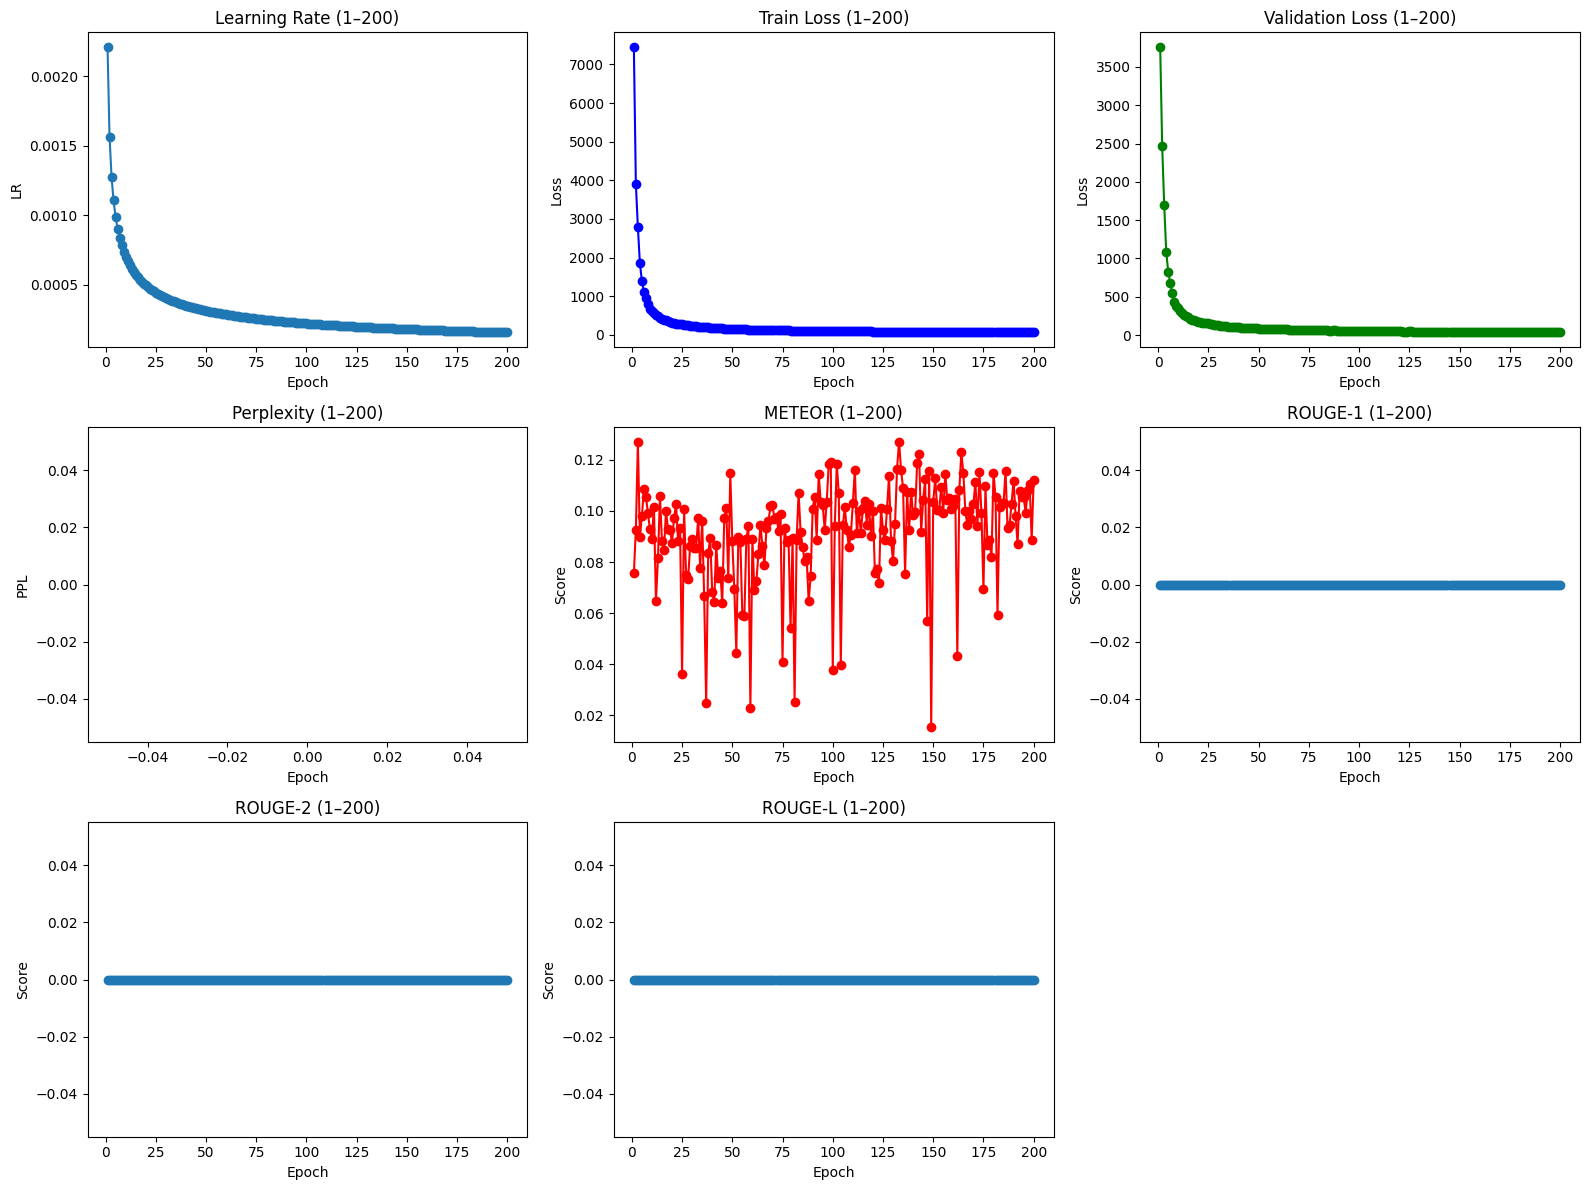

In [69]:
csv_path = save_path + "/history_200.csv"
plot_history(csv_path)

- 20 에폭 정도면 무난하게 loss가 수렴하고 30 정도면 완전히 수렴한다.
- Perplexity

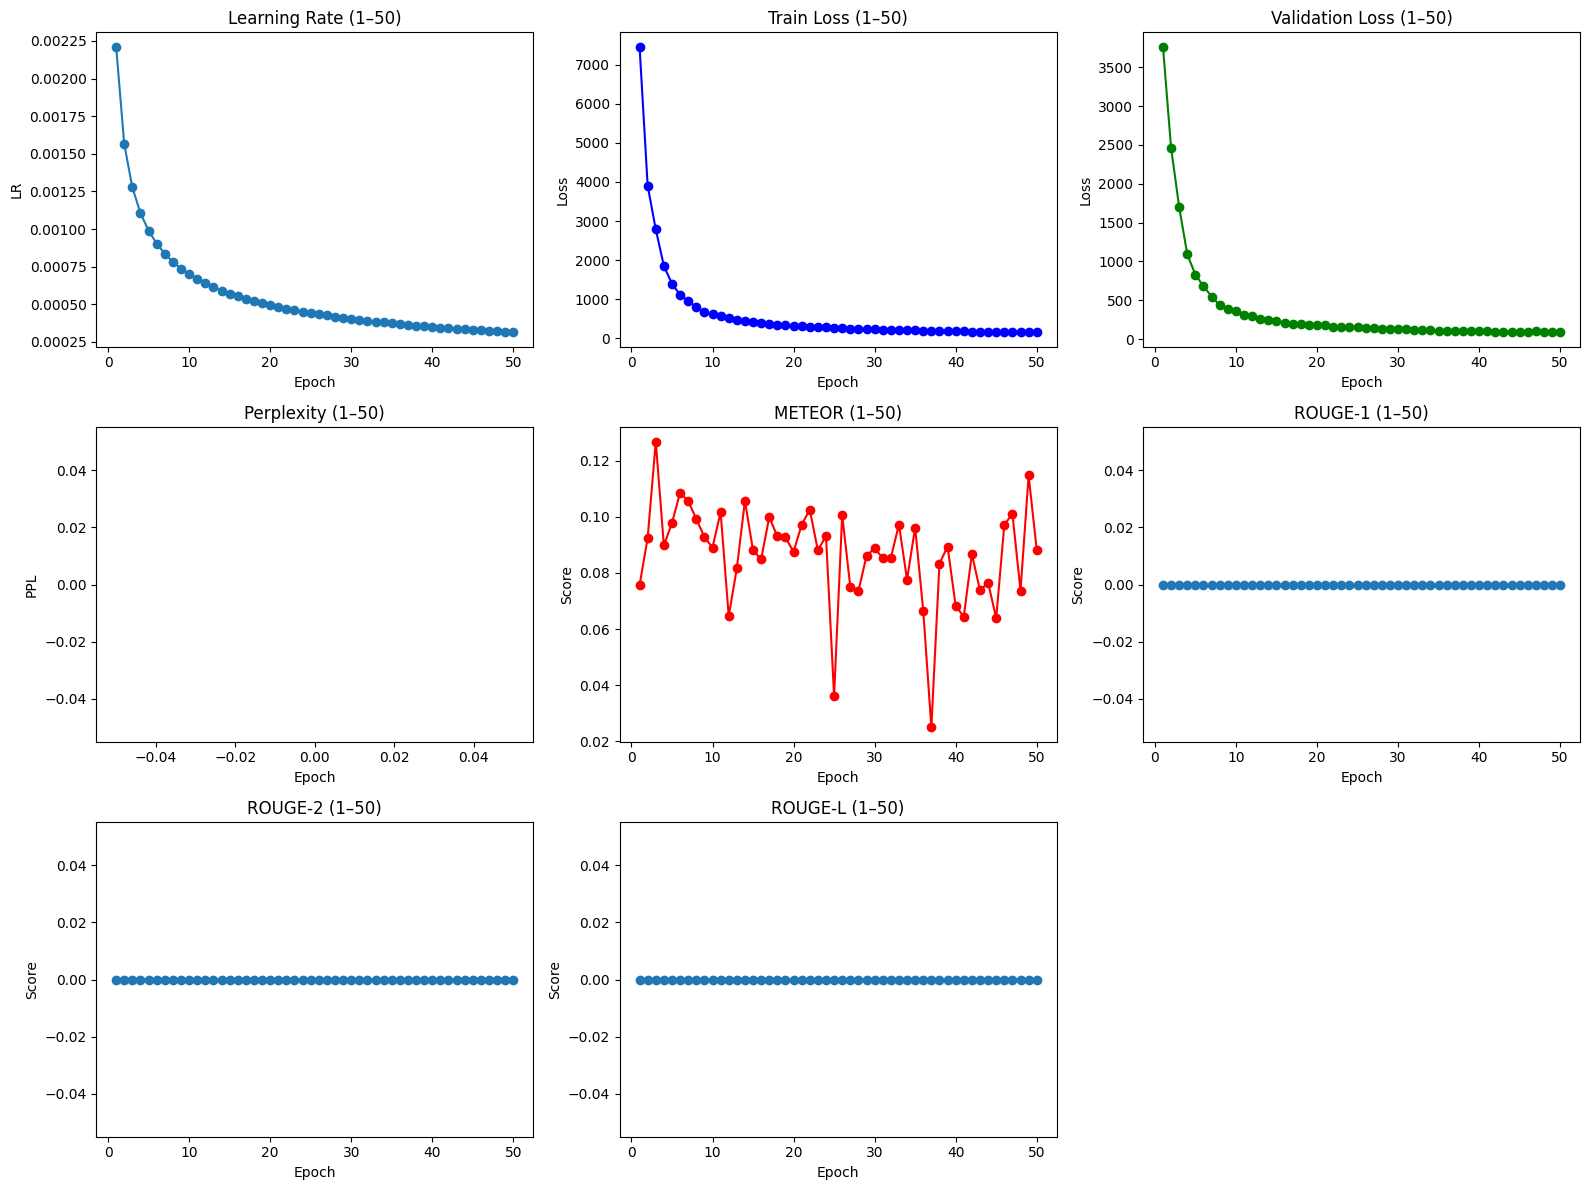

In [70]:
csv_path = save_path + "/history_200.csv"
plot_history(csv_path, start_epoch=1, end_epoch=50)

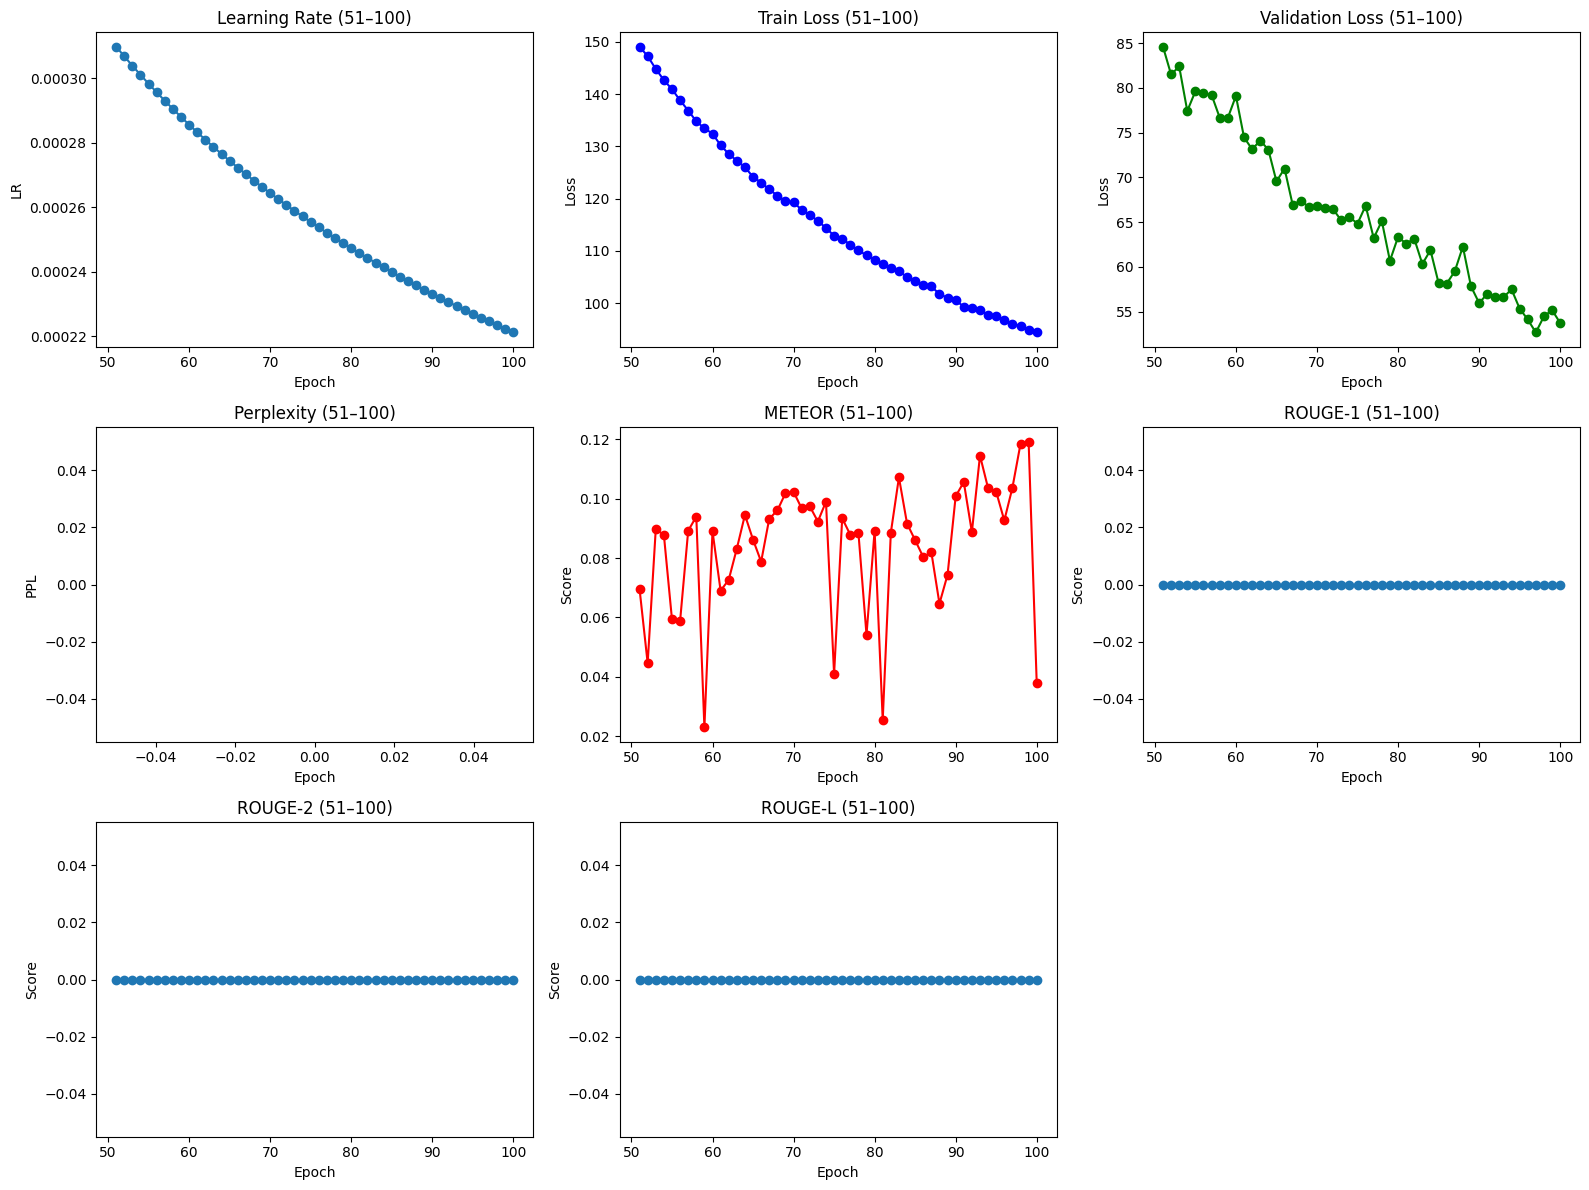

In [71]:
csv_path = save_path + "/history_200.csv"
plot_history(csv_path, start_epoch=51, end_epoch=100)

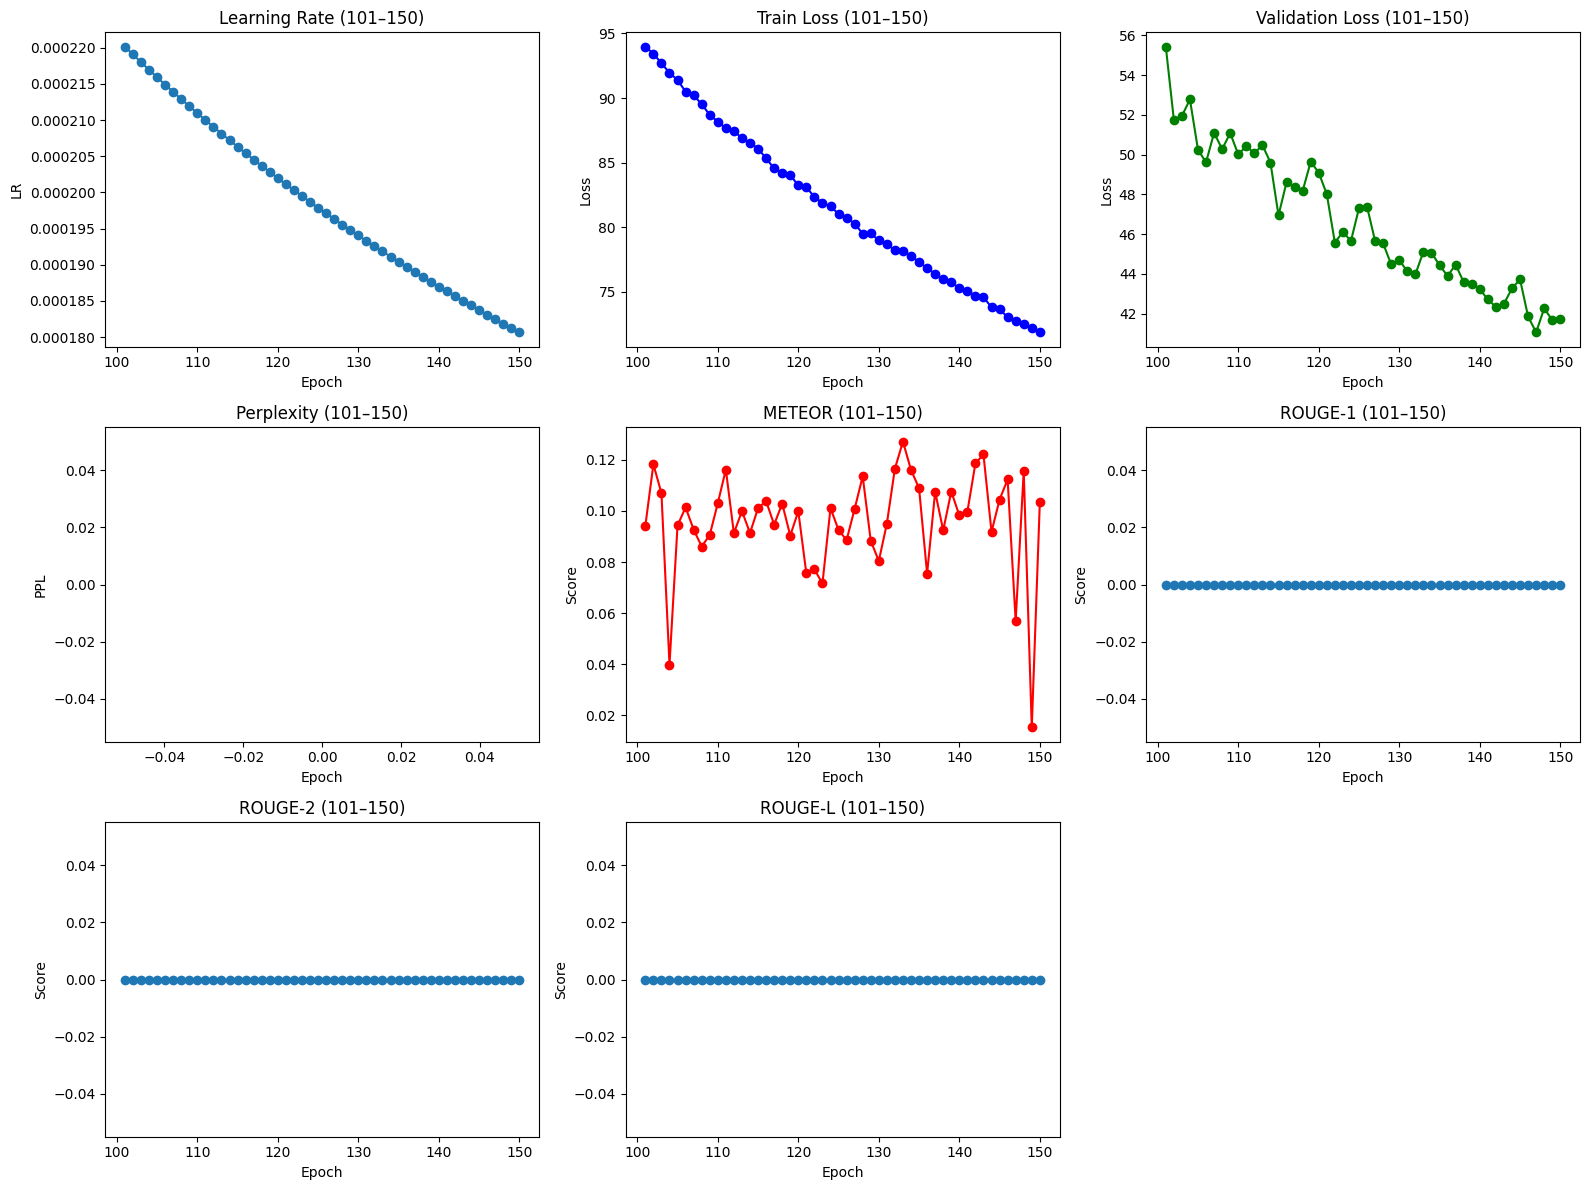

In [72]:
csv_path = save_path + "/history_200.csv"
plot_history(csv_path, start_epoch=101, end_epoch=150)

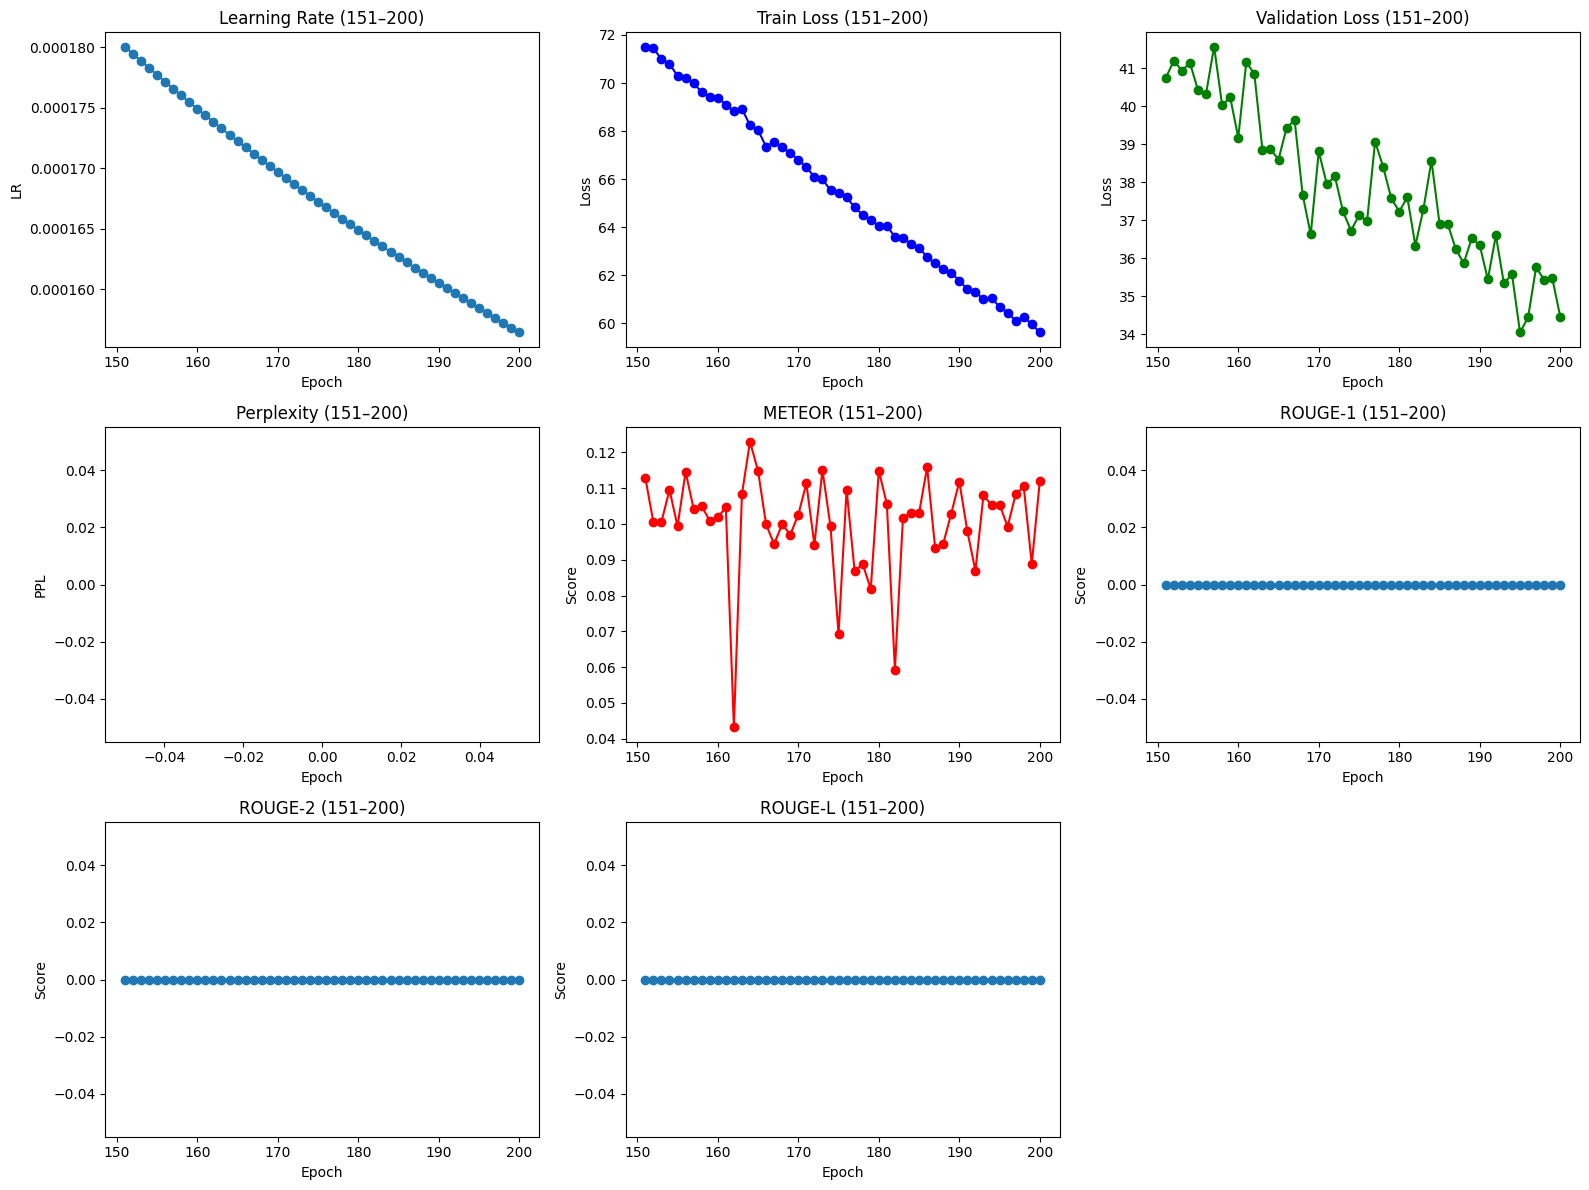

In [73]:
csv_path = save_path + "/history_200.csv"
plot_history(csv_path, start_epoch=151, end_epoch=200)

# Attention map 출력

In [61]:
PAD_ID = stoi["<pad>"]
BOS_ID = stoi["<s>"]
EOS_ID = stoi["</s>"]


In [62]:
def tokenize_kor(text: str):
    # 이미 쓰고 있는 mecab 토큰화 함수로 교체
    return mecab.morphs(text)  # 또는 네가 쓰는 래퍼


In [63]:
import torch

def sentence_to_ids(text, tokenize_fn, stoi, max_len, pad_id, bos_id, eos_id):
    """
    text        : 원본 문장 (str, 예: "지루하다, 놀러가고 싶어.")
    tokenize_fn : 한국어 토크나이저 함수 (예: mecab.morphs)
    stoi        : { token: id }
    """
    # 1) 토큰화
    tokens = tokenize_fn(text)  # 예: ["지루하", "다", ",", "놀러", "가", "고", "싶", "어", "."]

    # 2) BOS / EOS 추가
    tokens = ["<s>"] + tokens + ["</s>"]

    # 3) ID 변환 (unk 처리)
    ids = [stoi.get(tok, stoi["<unk>"]) for tok in tokens]

    # 4) 길이 자르기 + 패딩 (네가 쓰고 있던 함수 그대로 사용)
    #    pad_sequences_custom은 우리가 앞에서 eos 보호 로직까지 넣어둔 버전
    ids_padded = pad_sequences_custom(
        [ids],                 # 한 문장이라도 리스트로 감싸서 전달
        max_len=max_len,
        pad_value=pad_id,
        eos_value=eos_id,
    )  # shape: [1, max_len]

    return ids_padded.to(device)  # [1, max_len], device로 옮겨줌


In [64]:
def greedy_decode_with_attn(
    model,
    src_ids,          # [1, src_len] tensor
    generate_masks,
    max_len,
    bos_id,
    eos_id,
):
    """
    src_ids: [1, src_len]  (이미 device에 올라가 있는 상태)
    return:
      pred_ids : [1, tgt_len] (BOS~EOS 포함)
      enc_attns, dec_attns, dec_enc_attns : model이 반환하는 어텐션 리스트
    """
    model.eval()
    batch_size = src_ids.size(0)
    assert batch_size == 1, "시각화용이므로 batch_size=1로 사용하는 걸 권장합니다."

    # 시작 토큰만 있는 decoder 입력 [1, 1]
    tgt_in = torch.full(
        (batch_size, 1),
        bos_id,
        dtype=torch.long,
        device=src_ids.device,
    )

    with torch.no_grad():
        for _ in range(max_len - 1):
            enc_mask, dec_enc_mask, dec_mask = generate_masks(src_ids, tgt_in)
            enc_mask = enc_mask.to(src_ids.device)
            dec_enc_mask = dec_enc_mask.to(src_ids.device)
            dec_mask = dec_mask.to(src_ids.device)

            # model forward: 모든 시점에 대한 예측 + 어텐션들
            preds, enc_attns, dec_attns, dec_enc_attns = model(
                src_ids, tgt_in, enc_mask, dec_enc_mask, dec_mask
            )  # preds: [1, cur_len, vocab_size]

            next_logits = preds[:, -1, :]         # [1, vocab_size]
            next_token = next_logits.argmax(dim=-1)  # [1]

            # EOS면 멈출 준비
            tgt_in = torch.cat([tgt_in, next_token.unsqueeze(1)], dim=1)

            if next_token.item() == eos_id:
                break

    # 최종 decoder 입력(tgt_in)이 우리가 생성한 토큰 ID 전체
    return tgt_in, enc_attns, dec_attns, dec_enc_attns


In [65]:
def ids_to_tokens(ids, itos, pad_token="<pad>", bos_token="<s>", eos_token="</s>"):
    if torch.is_tensor(ids):
        ids = ids.tolist()
    tokens = []
    for i in ids:
        if i < 0 or i >= len(itos):
            tokens.append("<unk>")
            continue
        tok = itos[i]
        if tok == pad_token:
            continue
        if tok == bos_token:
            continue
        if tok == eos_token:
            break
        tokens.append(tok)
    return tokens  # ["잠깐", "쉬", "어도", "돼요", "."]

def ids_to_sentence(ids, itos, **kwargs):
    return " ".join(ids_to_tokens(ids, itos, **kwargs))


In [89]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

def plot_encdec_attention(
    dec_enc_attns,
    src_ids,
    tgt_ids,
    itos,
    layer_idx=-1
):
    """
    Multi-head enc-dec attention들을 하나로 합쳐서 시각화.
    - head 차원을 평균 내어 단일 attention map 생성.

    dec_enc_attns[layer]: [batch, n_heads, tgt_len, src_len]
    src_ids: [1, src_len]
    tgt_ids: [1, tgt_len]
    """

    fm.fontManager.addfont(fontpath)
    fontprop = fm.FontProperties(fname=fontpath)
    plt.rcParams["font.family"] = fontprop.get_name()

    # ------------------------------
    # 1) token 리스트로 변환
    # ------------------------------
    src_tokens = ids_to_tokens(src_ids[0], itos)
    tgt_tokens = ids_to_tokens(tgt_ids[0], itos)

    # ------------------------------
    # 2) attention tensor 꺼내서 head 평균
    #    dec_enc_attns[layer]: [batch=1, n_heads, tgt_len, src_len]
    # ------------------------------
    attn_all_heads = dec_enc_attns[layer_idx][0]      # [n_heads, tgt_len, src_len]
    attn_mean = attn_all_heads.mean(dim=0)           # [tgt_len, src_len]

    tgt_len = len(tgt_tokens)
    src_len = len(src_tokens)

    attn = attn_mean[:tgt_len, :src_len].detach().cpu().numpy()

    # ------------------------------
    # 3) heatmap 시각화
    # ------------------------------
    plt.figure(figsize=(max(8, src_len * 0.6), max(6, tgt_len * 0.6)))
    plt.imshow(attn, aspect='auto')
    plt.colorbar()

    plt.xticks(
        range(src_len),
        src_tokens,
        rotation=45,
        ha='right',
        fontproperties=fontprop,
    )
    plt.yticks(
        range(tgt_len),
        tgt_tokens,
        fontproperties=fontprop,
    )

    plt.xlabel("Source Tokens", fontproperties=fontprop)
    plt.ylabel("Target Tokens", fontproperties=fontprop)
    plt.title(f"Encoder-Decoder Attention (layer={layer_idx}, mean over heads)", fontproperties=fontprop)

    plt.tight_layout()
    plt.show()

# 결과

=== Generated Responses ===
1. input : 지루하다, 놀러가고 싶어.
   reply : 자신 만 걷 게 아니 지만 잘 할 기회 가 있 을 거 예요 . <end>



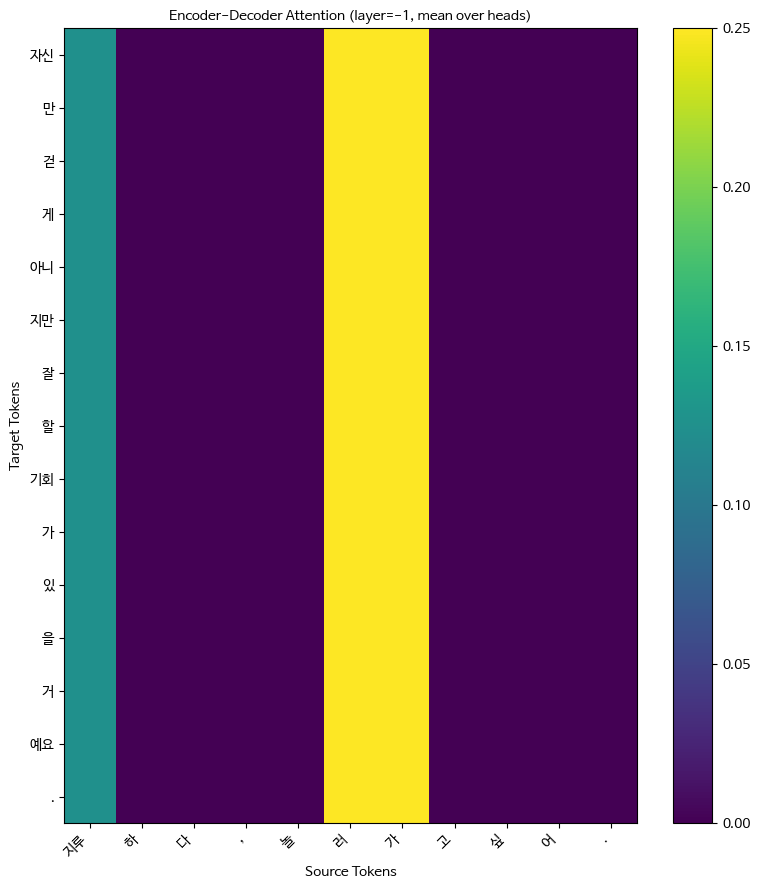

2. input : 오늘 일찍 일어났더니 피곤하다.
   reply : 자신 에게 나 글자 라도 긍정 적 부부 가 있 을 거 예요 . <end>



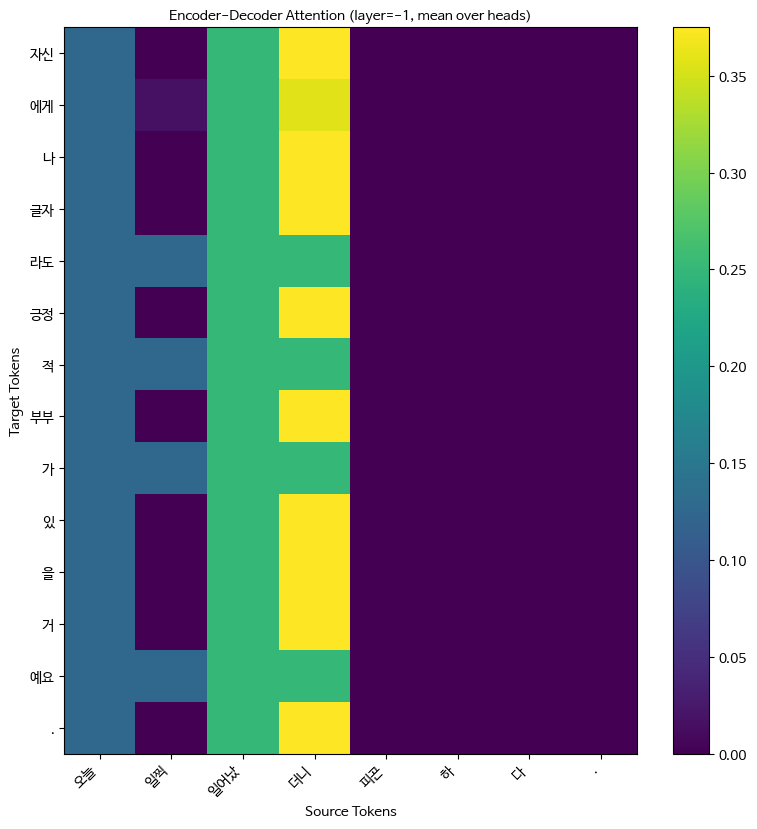

3. input : 간만에 여자친구랑 데이트 하기로 했어.
   reply : 자신 만 걷 다 보 세요 . <end>



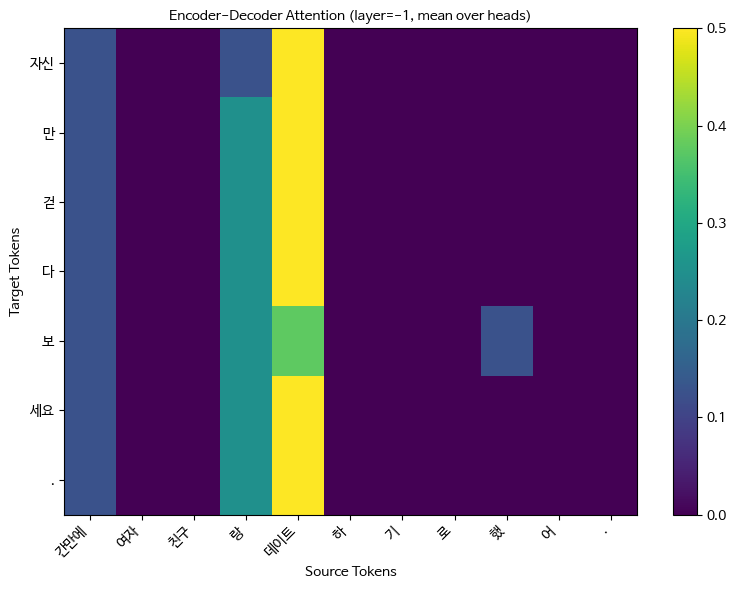

4. input : 집에 있는다는 소리야.
   reply : 자신 만 걷 게 아니 라면 정리 가 있 을 거 예요 . <end>



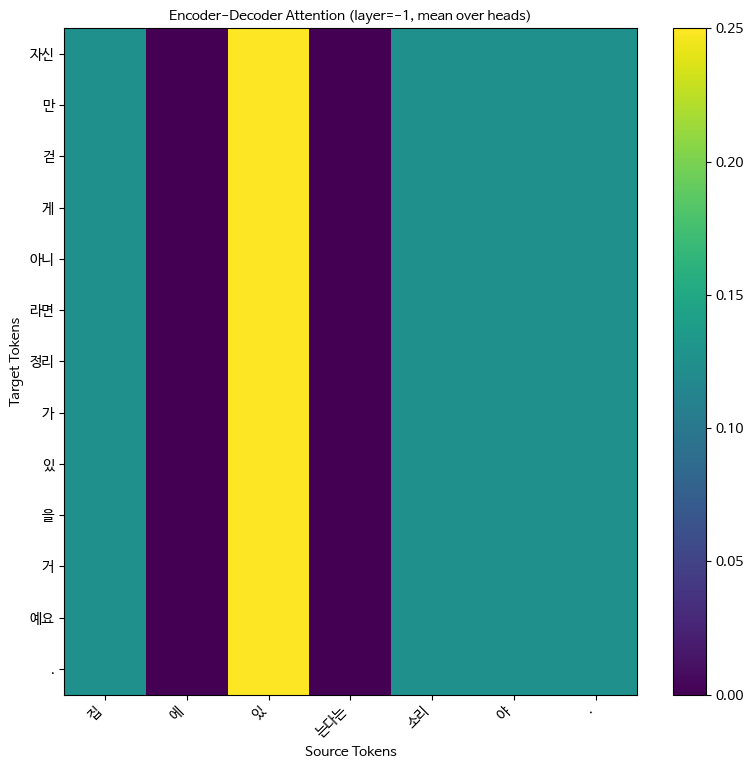

In [91]:
mecab = Mecab()

example_inputs = [
    "지루하다, 놀러가고 싶어.",
    "오늘 일찍 일어났더니 피곤하다.",
    "간만에 여자친구랑 데이트 하기로 했어.",
    "집에 있는다는 소리야.",
]

print("=== Generated Responses ===")
generated_ids_list = []
attn_for_vis = None
src_for_vis = None
tgt_for_vis = None

for i, sent in enumerate(example_inputs, start=1):
    # 1) 문장을 ID 텐서로 변환
    src_ids = sentence_to_ids(
        sent,
        tokenize_fn=tokenize_kor,  # 네 mecab 토크나이저 함수로 교체
        stoi=stoi,
        max_len=MAX_LEN,
        pad_id=PAD_ID,
        bos_id=BOS_ID,
        eos_id=EOS_ID,
    )  # [1, MAX_LEN] (device)

    # 2) 모델로 디코딩 + 어텐션 가져오기
    pred_ids, enc_attns, dec_attns, dec_enc_attns = greedy_decode_with_attn(
        transformer,
        src_ids,
        generate_masks,
        max_len=MAX_LEN,
        bos_id=BOS_ID,
        eos_id=EOS_ID,
    )

    attn_for_vis = dec_enc_attns
    src_for_vis = src_ids
    tgt_for_vis = pred_ids

    # 3) ID → 문장
    reply = ids_to_sentence(pred_ids[0], itos, pad_token="<pad>", bos_token="<s>", eos_token="</s>")

    print(f"{i}. input : {sent}")
    print(f"   reply : {reply} <end>")
    print()

    plot_encdec_attention(
        dec_enc_attns=attn_for_vis,
        src_ids=src_for_vis,
        tgt_ids=tgt_for_vis,
        itos=itos,
        layer_idx=-1
    )

    generated_ids_list.append(pred_ids)


# 고찰

# 회고